<a href="https://colab.research.google.com/github/wayne1123/Topic/blob/master/WGAN_MNIST_Pytorch_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

tcmalloc: large alloc 1073750016 bytes == 0x5c95c000 @  0x7f2e2bbdb2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
0.4.0
True


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data
import torchvision
from torch import autograd
from torchvision import datasets, transforms
from torchvision.models.inception import inception_v3
from torch.autograd import Variable

from skimage.color import lab2rgb, rgb2lab, rgb2gray
from sklearn.decomposition import PCA
from scipy.stats import entropy

In [3]:
BATCH = 16
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH,
                                         shuffle=False, num_workers=2)

Processing...
Done!


In [0]:
def one_hot(test,i=10):
  b = torch.zeros(test.shape[0],i)
  b[np.arange(test.shape[0]),test] = 1
  return b

#### It is WGAN-GP but the Discriminator(Critic) classifies the hand-digit examples into 0 ~9

#### Generator Structure

* Dense(128->256) + LeakyReLU + BN -> Reshape(-1, 16, 4, 4) 
* Convolution Block(16->64, filter=3) + LeakyReLU + BN 
* [Transposed Convolution(ch:64, filter=3, stride=2,)  + LeakyReLU + BN] X 3
* Convolution(64->1, filter=3) + Tanh, multiply 0.5 and add 0.5 - it generates better gradients than sigmoid..

#### Discriminator Structure

* [Convolution(filter=5, stride=2, ch_out = 4*ch_in) + LeakyReLU] X 2
* [Convolution(filter=3, stride=2, ch_out = 2*ch_in)+ LeakyReLU] X 2
* Output 1 : Convolution(filter=3, stride=1, ch_out=1, ch_in=64) -> Working as a Critic
* Output 2 : Linear (256 -> 10), Then Cross-entropy loss -> Working as a classifier

#### Characteristics

* It is conditional WGAN-GP : To control the output using the label variables
* Use the term **Discriminator** instead of **Critic**.. no specific reasons
* No Batch Normalization on Discriminator : Batch Normalization is known to have the dependency across the mini-batches. This affects the performance of the Discriminator badly.. so no Batch Normalization
* Simple is good - not necessary to use skipping.. adding residuals
* Learning rate: 1e-4
* Loss: **Wasserstein-1 Distance** for Critics, and **Softmax** for classification

#### Results

* It seems like that the Critics could label the generated images - but the quality of the generated images is not that good.
* Critics could discern whether the image is real and at the same time it could classify the images into labels. Two processes could be done simulataneously. 
* Maybe used to generate images & label them at the same time





In [0]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.conv1 = nn.Conv2d(16,64,3,1,1)
    self.conv2 = nn.ConvTranspose2d(64,64,3,2,1,1)
    self.conv3 = nn.ConvTranspose2d(64,64,3,2,1,1)
    self.conv4 = nn.ConvTranspose2d(64,64,3,2,1,1)
    self.conv5 = nn.Conv2d(64,1,3,1,1)
    self.bn0 = nn.BatchNorm1d(256)
    self.bn1 = nn.BatchNorm2d(64)
    self.bn2 = nn.BatchNorm2d(64)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(64)
    self.sigmoid = nn.Sigmoid()
    self.leakyrelu = nn.LeakyReLU(0.2)
    self.dense = nn.Linear(128,256)
    self.tanh = nn.Tanh()
    
  def forward(self):
    z = torch.randn(BATCH,128).cuda()
    #z = torch.cat([z,label],1)
    z = self.bn0(self.leakyrelu(self.dense(z)))
    z = z.reshape(-1,16,4,4)
    x = self.bn1(self.leakyrelu(self.conv1(z)))
    x = self.bn2(self.leakyrelu(self.conv2(x)))
    x = self.bn3(self.leakyrelu(self.conv3(x)))
    x = self.bn4(self.leakyrelu(self.conv4(x)))
    x = self.tanh(self.conv5(x)) * .5 + .5
    out = x[:,:,2:-2,2:-2]
    return out

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.leakyrelu = nn.LeakyReLU(0.2)
    self.conv1 = nn.Conv2d(1,4,5,2,2)
    self.avg1 = nn.AvgPool2d(7)
    self.conv2 = nn.Conv2d(4,16,5,2,2)
    self.avg2 = nn.AvgPool2d(2)
    self.conv3 = nn.Conv2d(16,64,3,2,1)
    self.conv4 = nn.Conv2d(64,256,3,2,1)
    self.conv5 = nn.Conv2d(256,256,2,2)
    self.avg = nn.AvgPool2d(2)
    self.linear1 = nn.Linear(256,1)
    self.linear2 = nn.Linear(256,10)
  def forward(self, x):
    z = self.leakyrelu(self.conv1(x))
    z = self.leakyrelu(self.conv2(z))
    z = self.leakyrelu(self.conv3(z))
    z = self.leakyrelu(self.conv4(z))
    z = self.leakyrelu(self.conv5(z))
    z = z.reshape(-1,256)
    out1 = self.linear1(z)
    out2 = self.linear2(z)
    return out1, out2
    
    
    

In [0]:
def gradient_penalty(C, real_data, fake_data, lamb=10):
    assert real_data.size() == fake_data.size()
    a = torch.rand(real_data.size(0),1).cuda()
    a = a\
    .expand(real_data.size(0), real_data.nelement()//real_data.size(0))\
    .contiguous()\
    .view(
    real_data.size(0),
    1,28,28
    )
    interpolated = Variable(a*real_data + (1-a)*fake_data, 
                            requires_grad=True)
    c, _ = C(interpolated)
    gradients = autograd.grad(
    c, interpolated, grad_outputs=(
    torch.ones(c.size()).cuda())
    ,create_graph=True, retain_graph=True)[0]
    return lamb*((1-(gradients).norm(2,dim=1))**2).mean()

In [0]:
def train(G,D, l=1e-4, n_epochs=15, start=0, weight_decay = True, classification=True):
  i = 0
  j = -1
  loss_list = []
  for epoch in range(start,n_epochs):
    if weight_decay:
      lr_ = l * (n_epochs - epoch+1) / n_epochs
    else:
      lr_ = l
    #lr_ = 1e-5
    G_op = optim.Adam(G.parameters(), lr = lr_, betas=(0.5,0.999))
    D_op = optim.Adam(D.parameters(), lr = lr_, betas=(0.5,0.999))
    for _, data in enumerate(trainloader):
      image, label = data
      y = one_hot(label)
      image, label = image.cuda(), label.cuda()
      D_op.zero_grad()
      sample = G()
      d_sample, _ = D(sample.detach())
      d_input, d_input2 = D(image)
      w_d = torch.mean(d_input) - torch.mean(d_sample)
      gp = gradient_penalty(D,image,sample,10)
      d_loss = -w_d + gp
      
      if classification:
        bce = ce(d_input2,label)
        d_loss += bce
        
      d_loss.backward()
      D_op.step()
      
      
      
      if i % 5 == 1:
        G_op.zero_grad()
        sample_ = G()
        d_sample, _ = D(sample_)
        g_loss = -torch.mean(d_sample)
        g_loss.backward()
        G_op.step()
        if classification:
          loss_list.append([w_d.data[0],d_loss.data[0],bce.data[0],g_loss.data[0]])
        else:
          loss_list.append([w_d.data[0],d_loss.data[0],g_loss.data[0]])
        
      if i%100 == 1:
        if classification:
          print("epoch={}, iteration={}, WD={}, D_loss={}, bce={}, G_loss={}".format(epoch,i,w_d.data[0],d_loss.data[0], bce.data[0],g_loss.data[0]))
        else:
          print("epoch={}, iteration={}, WD={}, D_loss={}, G_loss={}".format(epoch,i,w_d.data[0],d_loss.data[0],g_loss.data[0]))
      i += 1
      if epoch > j:
        print("learning rate : {} ".format(lr_))
        display = G()
        display = display.detach()
        if classification:
          _, labels = D(display)
          predicted_label = torch.max(labels.data, 1)
        display = display[:16]
        fig = plt.figure(figsize=(6,6))
        gs = gridspec.GridSpec(4,4)
        gs.update(wspace=0.05, hspace=0.05)
        for j, sample in enumerate(display):
          ax = plt.subplot(gs[j])
          plt.axis('off')
          ax.set_xticklabels([])
          ax.set_yticklabels([])
          ax.set_aspect('equal')
          plt.imshow(sample.reshape(28,28),cmap = plt.cm.gray)
        plt.show()
        if classification:
          print("Labels : ", predicted_label)
          with torch.no_grad():
            label_list = []
            total = 0
            correct = 0
            for data in testloader:
              image, labels = data
              image, labels = image.cuda(), labels.cuda()
              _, output = D(image)
              _, predicted = torch.max(output.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
            print("Classification Accuracy : %d %% " % (100*correct/total))
            
        j = epoch
  return loss_list
        

learning rate : 0.0001 


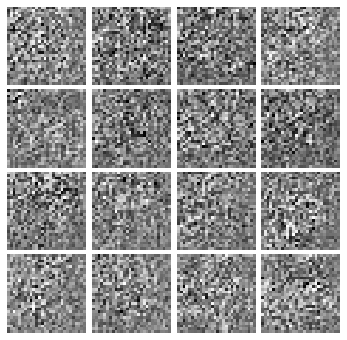

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch=0, iteration=1, WD=0.009623736143112183, D_loss=9.987174034118652, G_loss=-0.02335420250892639
epoch=0, iteration=101, WD=763.8546142578125, D_loss=-610.7960815429688, G_loss=1067.193603515625
epoch=0, iteration=201, WD=2647.831787109375, D_loss=-1724.6212158203125, G_loss=2607.17041015625
epoch=0, iteration=301, WD=2657.69775390625, D_loss=-1544.56494140625, G_loss=2405.538818359375
epoch=0, iteration=401, WD=2166.589111328125, D_loss=-1212.8604736328125, G_loss=1926.3817138671875
epoch=0, iteration=501, WD=1827.068359375, D_loss=-1015.9273071289062, G_loss=1652.8446044921875
epoch=0, iteration=601, WD=1421.561767578125, D_loss=-751.4906616210938, G_loss=1292.9310302734375
epoch=0, iteration=701, WD=1005.3114013671875, D_loss=-530.7080078125, G_loss=764.694580078125
epoch=0, iteration=801, WD=661.6463012695312, D_loss=-364.2252197265625, G_loss=452.62371826171875
epoch=0, iteration=901, WD=397.70452880859375, D_loss=-222.8594207763672, G_loss=191.09239196777344
epoch=0, iteratio

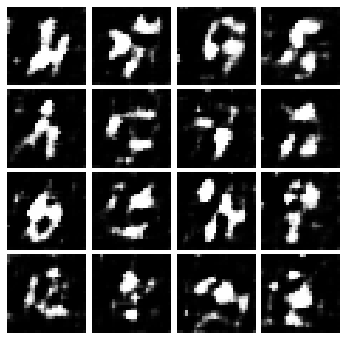

epoch=1, iteration=3801, WD=49.36700439453125, D_loss=-27.931154251098633, G_loss=3.539374828338623
epoch=1, iteration=3901, WD=28.47809600830078, D_loss=-13.756720542907715, G_loss=-89.77821350097656
epoch=1, iteration=4001, WD=35.45638656616211, D_loss=-19.002941131591797, G_loss=-4.536773204803467
epoch=1, iteration=4101, WD=34.22137451171875, D_loss=-22.250465393066406, G_loss=-84.08269500732422
epoch=1, iteration=4201, WD=33.563873291015625, D_loss=-25.87152862548828, G_loss=-173.97415161132812
epoch=1, iteration=4301, WD=32.18801498413086, D_loss=-21.05453872680664, G_loss=-59.93596649169922
epoch=1, iteration=4401, WD=22.984466552734375, D_loss=-15.542895317077637, G_loss=-233.86215209960938
epoch=1, iteration=4501, WD=38.681724548339844, D_loss=-28.594867706298828, G_loss=-34.97235107421875
epoch=1, iteration=4601, WD=53.29486083984375, D_loss=-31.528818130493164, G_loss=83.75203704833984
epoch=1, iteration=4701, WD=30.197189331054688, D_loss=-22.52602767944336, G_loss=-191.561

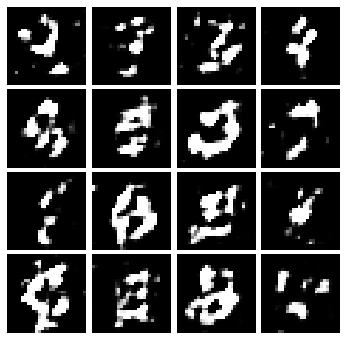

epoch=2, iteration=7501, WD=31.917133331298828, D_loss=-21.98793601989746, G_loss=-20.194101333618164
epoch=2, iteration=7601, WD=28.332408905029297, D_loss=-18.172550201416016, G_loss=33.50703048706055
epoch=2, iteration=7701, WD=39.672786712646484, D_loss=-27.728803634643555, G_loss=91.10441589355469
epoch=2, iteration=7801, WD=26.77935791015625, D_loss=-9.438232421875, G_loss=144.5661163330078
epoch=2, iteration=7901, WD=38.88446807861328, D_loss=-28.127851486206055, G_loss=36.29956817626953
epoch=2, iteration=8001, WD=30.248964309692383, D_loss=-18.21715545654297, G_loss=7.558429718017578
epoch=2, iteration=8101, WD=44.68305969238281, D_loss=-32.82831954956055, G_loss=28.753841400146484
epoch=2, iteration=8201, WD=49.713035583496094, D_loss=-33.9836540222168, G_loss=-31.954872131347656
epoch=2, iteration=8301, WD=39.06394958496094, D_loss=-23.762025833129883, G_loss=139.28509521484375
epoch=2, iteration=8401, WD=30.644317626953125, D_loss=-13.868780136108398, G_loss=191.85656738281

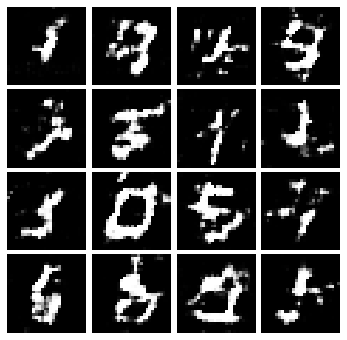

epoch=3, iteration=11301, WD=40.687225341796875, D_loss=-27.06794548034668, G_loss=167.34500122070312
epoch=3, iteration=11401, WD=45.34295654296875, D_loss=-29.894271850585938, G_loss=227.1905059814453
epoch=3, iteration=11501, WD=39.394744873046875, D_loss=-26.82587242126465, G_loss=174.87698364257812
epoch=3, iteration=11601, WD=29.364105224609375, D_loss=-16.563241958618164, G_loss=173.4505157470703
epoch=3, iteration=11701, WD=38.56373596191406, D_loss=-27.003761291503906, G_loss=182.53282165527344
epoch=3, iteration=11801, WD=22.141695022583008, D_loss=-9.702608108520508, G_loss=20.071308135986328
epoch=3, iteration=11901, WD=34.89764404296875, D_loss=-23.805917739868164, G_loss=131.6496124267578
epoch=3, iteration=12001, WD=30.856109619140625, D_loss=-18.964008331298828, G_loss=162.60690307617188
epoch=3, iteration=12101, WD=29.248586654663086, D_loss=-19.09072494506836, G_loss=19.03436851501465
epoch=3, iteration=12201, WD=23.857650756835938, D_loss=-12.87393569946289, G_loss=1

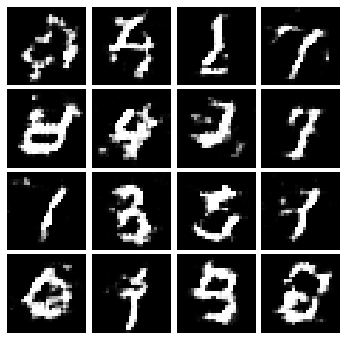

epoch=4, iteration=15001, WD=24.86972427368164, D_loss=-17.171802520751953, G_loss=81.96414947509766
epoch=4, iteration=15101, WD=19.531326293945312, D_loss=-9.437699317932129, G_loss=220.7860107421875
epoch=4, iteration=15201, WD=25.782470703125, D_loss=-18.630971908569336, G_loss=159.2829132080078
epoch=4, iteration=15301, WD=14.359954833984375, D_loss=-0.6218376159667969, G_loss=267.5097351074219
epoch=4, iteration=15401, WD=24.737350463867188, D_loss=-16.80573272705078, G_loss=98.33838653564453
epoch=4, iteration=15501, WD=17.38671875, D_loss=-9.712509155273438, G_loss=166.0750732421875
epoch=4, iteration=15601, WD=23.575485229492188, D_loss=-15.2653169631958, G_loss=191.04261779785156
epoch=4, iteration=15701, WD=15.291229248046875, D_loss=-7.467468738555908, G_loss=206.79539489746094
epoch=4, iteration=15801, WD=45.210811614990234, D_loss=-34.908592224121094, G_loss=-52.19972229003906
epoch=4, iteration=15901, WD=34.5240478515625, D_loss=-21.859638214111328, G_loss=302.2793273925

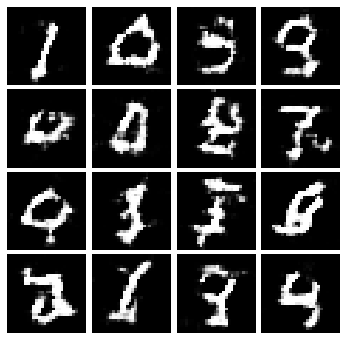

epoch=5, iteration=18801, WD=18.79265594482422, D_loss=-12.360431671142578, G_loss=55.304420471191406
epoch=5, iteration=18901, WD=26.411209106445312, D_loss=-19.369359970092773, G_loss=129.70187377929688
epoch=5, iteration=19001, WD=24.28542137145996, D_loss=-17.398502349853516, G_loss=-42.65432357788086
epoch=5, iteration=19101, WD=22.563980102539062, D_loss=-14.432438850402832, G_loss=157.4296417236328
epoch=5, iteration=19201, WD=27.40876007080078, D_loss=-20.603193283081055, G_loss=124.92198181152344
epoch=5, iteration=19301, WD=29.143714904785156, D_loss=-22.08333969116211, G_loss=10.278725624084473
epoch=5, iteration=19401, WD=10.084775924682617, D_loss=-3.5071167945861816, G_loss=23.531230926513672
epoch=5, iteration=19501, WD=24.965866088867188, D_loss=-17.446788787841797, G_loss=179.04171752929688
epoch=5, iteration=19601, WD=26.374773025512695, D_loss=-18.790212631225586, G_loss=19.43157386779785
epoch=5, iteration=19701, WD=8.035736083984375, D_loss=5.239686012268066, G_los

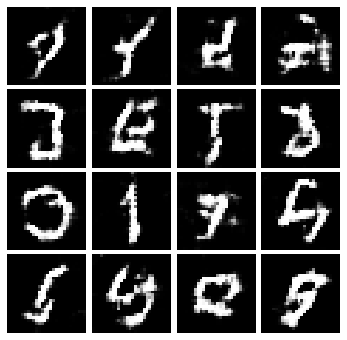

epoch=6, iteration=22501, WD=15.31667709350586, D_loss=-9.888629913330078, G_loss=55.394779205322266
epoch=6, iteration=22601, WD=14.340202331542969, D_loss=-7.509766578674316, G_loss=86.8311767578125
epoch=6, iteration=22701, WD=18.053699493408203, D_loss=-11.615074157714844, G_loss=-57.88093566894531
epoch=6, iteration=22801, WD=13.980133056640625, D_loss=-6.390930652618408, G_loss=158.06765747070312
epoch=6, iteration=22901, WD=13.18692398071289, D_loss=-6.725968360900879, G_loss=-37.22026824951172
epoch=6, iteration=23001, WD=32.97840881347656, D_loss=-23.412811279296875, G_loss=258.4220275878906
epoch=6, iteration=23101, WD=10.242647171020508, D_loss=-4.719580173492432, G_loss=-29.015592575073242
epoch=6, iteration=23201, WD=21.08566665649414, D_loss=-15.533023834228516, G_loss=34.15721130371094
epoch=6, iteration=23301, WD=19.25470733642578, D_loss=-12.126676559448242, G_loss=-112.5959243774414
epoch=6, iteration=23401, WD=18.13701629638672, D_loss=-10.871360778808594, G_loss=158

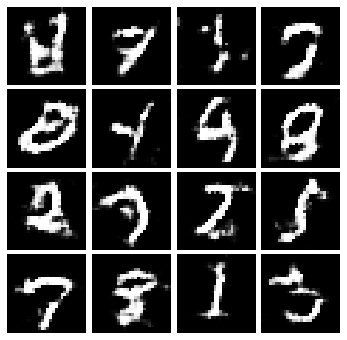

epoch=7, iteration=26301, WD=12.303722381591797, D_loss=-6.117005348205566, G_loss=-60.33892822265625
epoch=7, iteration=26401, WD=11.795509338378906, D_loss=-4.640074729919434, G_loss=117.04475402832031
epoch=7, iteration=26501, WD=-3.3081817626953125, D_loss=13.065898895263672, G_loss=-192.85179138183594
epoch=7, iteration=26601, WD=10.012372970581055, D_loss=-4.388049125671387, G_loss=-3.320345163345337
epoch=7, iteration=26701, WD=16.678878784179688, D_loss=-7.688612937927246, G_loss=221.8254852294922
epoch=7, iteration=26801, WD=9.874038696289062, D_loss=-3.8155598640441895, G_loss=-96.34008026123047
epoch=7, iteration=26901, WD=3.9183425903320312, D_loss=1.6865692138671875, G_loss=-73.59025573730469
epoch=7, iteration=27001, WD=18.559539794921875, D_loss=-13.181007385253906, G_loss=102.9202880859375
epoch=7, iteration=27101, WD=10.349740028381348, D_loss=-5.212080955505371, G_loss=1.3996212482452393
epoch=7, iteration=27201, WD=13.54168701171875, D_loss=-7.106289863586426, G_loss

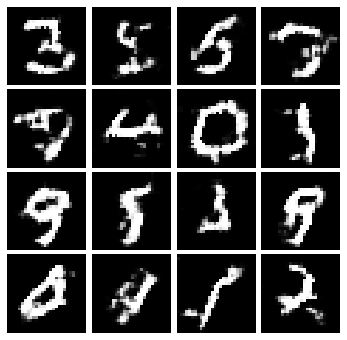

epoch=8, iteration=30001, WD=15.821990966796875, D_loss=-7.808795928955078, G_loss=157.8145294189453
epoch=8, iteration=30101, WD=12.150703430175781, D_loss=-6.0077290534973145, G_loss=89.63188171386719
epoch=8, iteration=30201, WD=16.5308895111084, D_loss=-10.952262878417969, G_loss=1.9564204216003418
epoch=8, iteration=30301, WD=17.841014862060547, D_loss=-11.382447242736816, G_loss=2.2961103916168213
epoch=8, iteration=30401, WD=15.93802261352539, D_loss=-9.18679428100586, G_loss=-61.45952224731445
epoch=8, iteration=30501, WD=32.273468017578125, D_loss=-24.2923641204834, G_loss=171.10482788085938
epoch=8, iteration=30601, WD=24.683319091796875, D_loss=-17.785808563232422, G_loss=180.1597900390625
epoch=8, iteration=30701, WD=24.18846893310547, D_loss=-18.303577423095703, G_loss=65.71988677978516
epoch=8, iteration=30801, WD=10.909015655517578, D_loss=-4.701826572418213, G_loss=42.66878890991211
epoch=8, iteration=30901, WD=27.207740783691406, D_loss=-21.494361877441406, G_loss=-82.

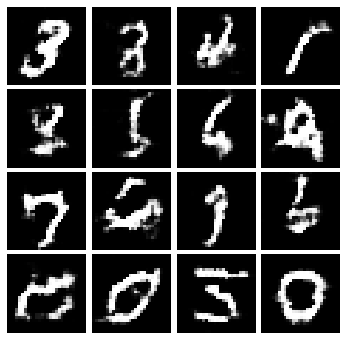

epoch=9, iteration=33801, WD=22.465835571289062, D_loss=-17.205469131469727, G_loss=-20.615550994873047
epoch=9, iteration=33901, WD=5.7980804443359375, D_loss=-0.2015857696533203, G_loss=54.91143035888672
epoch=9, iteration=34001, WD=2.7488861083984375, D_loss=3.6370086669921875, G_loss=-116.7465591430664
epoch=9, iteration=34101, WD=11.99388599395752, D_loss=-7.192178249359131, G_loss=2.5176408290863037
epoch=9, iteration=34201, WD=19.677291870117188, D_loss=-12.417102813720703, G_loss=131.34048461914062
epoch=9, iteration=34301, WD=15.854141235351562, D_loss=-10.010744094848633, G_loss=70.60267639160156
epoch=9, iteration=34401, WD=14.082061767578125, D_loss=-8.878083229064941, G_loss=28.87238883972168
epoch=9, iteration=34501, WD=19.91060447692871, D_loss=-13.46191120147705, G_loss=45.908817291259766
epoch=9, iteration=34601, WD=13.788055419921875, D_loss=-8.488103866577148, G_loss=60.908843994140625
epoch=9, iteration=34701, WD=22.458518981933594, D_loss=-17.055606842041016, G_los

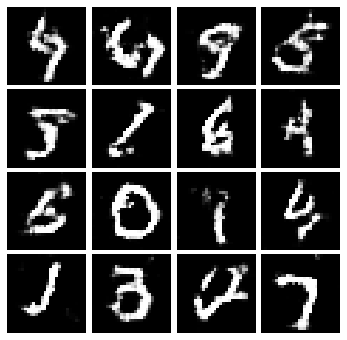

epoch=10, iteration=37501, WD=14.920238494873047, D_loss=-9.995431900024414, G_loss=-73.40042877197266
epoch=10, iteration=37601, WD=12.095352172851562, D_loss=-7.009342193603516, G_loss=-92.33943939208984
epoch=10, iteration=37701, WD=6.037731647491455, D_loss=-1.1096444129943848, G_loss=15.238602638244629
epoch=10, iteration=37801, WD=11.953231811523438, D_loss=-7.213274955749512, G_loss=-77.15894317626953
epoch=10, iteration=37901, WD=12.723041534423828, D_loss=-7.694357872009277, G_loss=-52.30366516113281
epoch=10, iteration=38001, WD=14.984060287475586, D_loss=-9.860142707824707, G_loss=46.18368911743164
epoch=10, iteration=38101, WD=11.52328109741211, D_loss=-6.551090240478516, G_loss=54.93782043457031
epoch=10, iteration=38201, WD=19.91990852355957, D_loss=-14.337956428527832, G_loss=25.244813919067383
epoch=10, iteration=38301, WD=14.597434997558594, D_loss=-9.768150329589844, G_loss=-32.4002799987793
epoch=10, iteration=38401, WD=8.56268310546875, D_loss=-2.8210506439208984, G

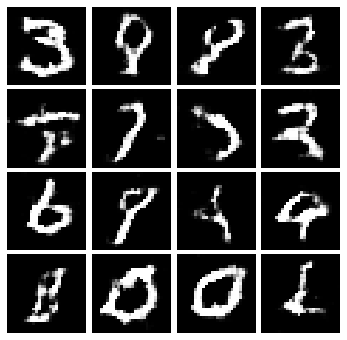

epoch=11, iteration=41301, WD=28.048622131347656, D_loss=-21.42559051513672, G_loss=115.48231506347656
epoch=11, iteration=41401, WD=14.774372100830078, D_loss=-9.293573379516602, G_loss=66.77583312988281
epoch=11, iteration=41501, WD=10.783712387084961, D_loss=-6.0234761238098145, G_loss=32.89858627319336
epoch=11, iteration=41601, WD=8.37335205078125, D_loss=-3.69918155670166, G_loss=-52.75592041015625
epoch=11, iteration=41701, WD=-0.875457763671875, D_loss=5.4454498291015625, G_loss=-40.63908386230469
epoch=11, iteration=41801, WD=13.933387756347656, D_loss=-8.903584480285645, G_loss=57.340877532958984
epoch=11, iteration=41901, WD=23.600807189941406, D_loss=-18.054668426513672, G_loss=94.93054962158203
epoch=11, iteration=42001, WD=12.340621948242188, D_loss=-6.918464183807373, G_loss=-89.58735656738281
epoch=11, iteration=42101, WD=23.522048950195312, D_loss=-16.803010940551758, G_loss=-151.57540893554688
epoch=11, iteration=42201, WD=19.040618896484375, D_loss=-13.37978935241699

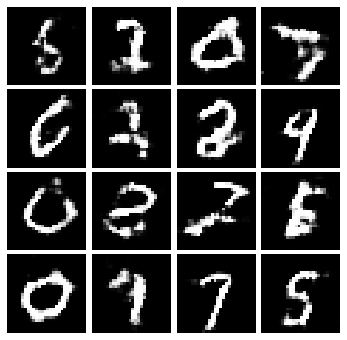

epoch=12, iteration=45001, WD=16.9368896484375, D_loss=-12.433122634887695, G_loss=-63.3466911315918
epoch=12, iteration=45101, WD=16.379913330078125, D_loss=-10.970030784606934, G_loss=23.289033889770508
epoch=12, iteration=45201, WD=22.507919311523438, D_loss=-17.92294692993164, G_loss=-64.78905487060547
epoch=12, iteration=45301, WD=16.575239181518555, D_loss=-11.711969375610352, G_loss=-28.15216064453125
epoch=12, iteration=45401, WD=-3.5238800048828125, D_loss=9.601612091064453, G_loss=-136.61981201171875
epoch=12, iteration=45501, WD=1.4750518798828125, D_loss=3.3651833534240723, G_loss=-61.620704650878906
epoch=12, iteration=45601, WD=11.124244689941406, D_loss=-6.621918678283691, G_loss=-41.553653717041016
epoch=12, iteration=45701, WD=7.646522521972656, D_loss=-2.5047354698181152, G_loss=-25.352062225341797
epoch=12, iteration=45801, WD=12.376846313476562, D_loss=-7.235193252563477, G_loss=-69.00788116455078
epoch=12, iteration=45901, WD=1.7519760131835938, D_loss=2.9585843086

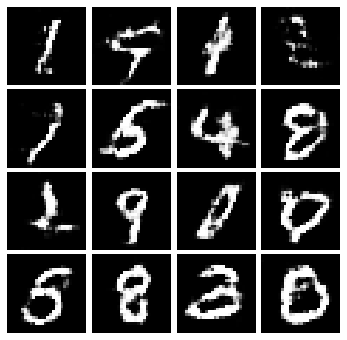

epoch=13, iteration=48801, WD=23.003490447998047, D_loss=-18.185216903686523, G_loss=74.97904968261719
epoch=13, iteration=48901, WD=17.066286087036133, D_loss=-11.99667739868164, G_loss=6.9593186378479
epoch=13, iteration=49001, WD=20.505958557128906, D_loss=-14.460736274719238, G_loss=-121.47103881835938
epoch=13, iteration=49101, WD=18.33551788330078, D_loss=-12.354722023010254, G_loss=-112.79359436035156
epoch=13, iteration=49201, WD=12.444694519042969, D_loss=-7.518553256988525, G_loss=-67.3519058227539
epoch=13, iteration=49301, WD=9.945577621459961, D_loss=-5.6094231605529785, G_loss=-5.82569694519043
epoch=13, iteration=49401, WD=12.26984977722168, D_loss=-7.532355785369873, G_loss=-19.027849197387695
epoch=13, iteration=49501, WD=8.062812805175781, D_loss=-3.0749998092651367, G_loss=-18.203310012817383
epoch=13, iteration=49601, WD=14.9422607421875, D_loss=-10.434556007385254, G_loss=-17.566680908203125
epoch=13, iteration=49701, WD=0.24439620971679688, D_loss=4.24054050445556

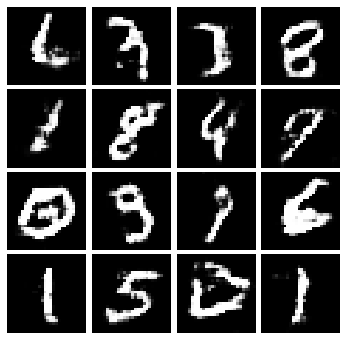

epoch=14, iteration=52501, WD=12.966667175292969, D_loss=-7.668294906616211, G_loss=-99.1000747680664
epoch=14, iteration=52601, WD=16.14051055908203, D_loss=-10.426055908203125, G_loss=-110.40154266357422
epoch=14, iteration=52701, WD=24.032962799072266, D_loss=-19.103487014770508, G_loss=-70.82414245605469
epoch=14, iteration=52801, WD=8.227867126464844, D_loss=-3.0377755165100098, G_loss=-31.661760330200195
epoch=14, iteration=52901, WD=12.995414733886719, D_loss=-8.147568702697754, G_loss=4.35197639465332
epoch=14, iteration=53001, WD=9.218206405639648, D_loss=-3.908407688140869, G_loss=-7.914318561553955
epoch=14, iteration=53101, WD=19.351856231689453, D_loss=-13.289787292480469, G_loss=-66.91918182373047
epoch=14, iteration=53201, WD=12.51926040649414, D_loss=-7.715658664703369, G_loss=-63.34073257446289
epoch=14, iteration=53301, WD=14.499420166015625, D_loss=-9.177854537963867, G_loss=-54.54043960571289
epoch=14, iteration=53401, WD=7.889571189880371, D_loss=-2.872747898101806

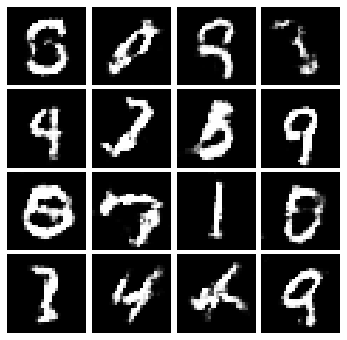

epoch=15, iteration=56301, WD=18.146469116210938, D_loss=-11.89422607421875, G_loss=-76.80152130126953
epoch=15, iteration=56401, WD=3.66064453125, D_loss=1.8384900093078613, G_loss=-83.4499282836914
epoch=15, iteration=56501, WD=8.05206298828125, D_loss=-2.5911812782287598, G_loss=-85.10761260986328
epoch=15, iteration=56601, WD=12.008453369140625, D_loss=-6.480773448944092, G_loss=-96.88680267333984
epoch=15, iteration=56701, WD=-0.5326118469238281, D_loss=6.85590934753418, G_loss=-42.32459259033203
epoch=15, iteration=56801, WD=6.1129302978515625, D_loss=0.511253833770752, G_loss=-123.6667709350586
epoch=15, iteration=56901, WD=13.772453308105469, D_loss=-7.834752082824707, G_loss=-75.86648559570312
epoch=15, iteration=57001, WD=8.71630859375, D_loss=-1.7212505340576172, G_loss=-116.27184295654297
epoch=15, iteration=57101, WD=9.329017639160156, D_loss=-3.6460037231445312, G_loss=-72.35350799560547
epoch=15, iteration=57201, WD=7.0600738525390625, D_loss=-2.2582006454467773, G_loss=

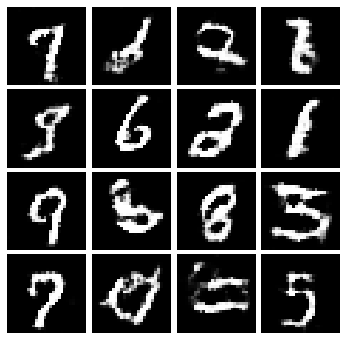

epoch=16, iteration=60001, WD=4.8869781494140625, D_loss=0.03073883056640625, G_loss=-32.20649337768555
epoch=16, iteration=60101, WD=3.7311973571777344, D_loss=2.2380971908569336, G_loss=35.46354675292969
epoch=16, iteration=60201, WD=15.730010986328125, D_loss=-10.126301765441895, G_loss=29.918996810913086
epoch=16, iteration=60301, WD=21.637510299682617, D_loss=-16.207412719726562, G_loss=-10.605894088745117
epoch=16, iteration=60401, WD=16.521072387695312, D_loss=-10.309154510498047, G_loss=-102.10164642333984
epoch=16, iteration=60501, WD=1.4535093307495117, D_loss=4.624521732330322, G_loss=27.629745483398438
epoch=16, iteration=60601, WD=12.681684494018555, D_loss=-7.767454147338867, G_loss=-17.922101974487305
epoch=16, iteration=60701, WD=6.606620788574219, D_loss=-0.3477969169616699, G_loss=-49.77864456176758
epoch=16, iteration=60801, WD=11.753692626953125, D_loss=-6.3138346672058105, G_loss=-102.19068908691406
epoch=16, iteration=60901, WD=31.66729736328125, D_loss=-25.954181

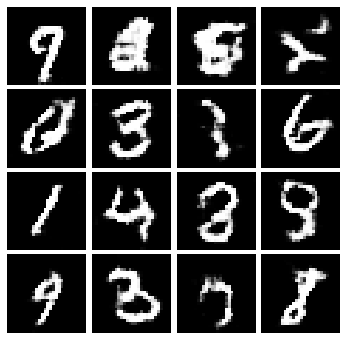

epoch=17, iteration=63801, WD=16.451473236083984, D_loss=-10.704285621643066, G_loss=-58.75740432739258
epoch=17, iteration=63901, WD=5.561515808105469, D_loss=1.4297199249267578, G_loss=-70.2442626953125
epoch=17, iteration=64001, WD=18.721168518066406, D_loss=-12.509294509887695, G_loss=-63.61651611328125
epoch=17, iteration=64101, WD=20.827064514160156, D_loss=-15.209126472473145, G_loss=-30.14612579345703
epoch=17, iteration=64201, WD=18.651004791259766, D_loss=-12.993850708007812, G_loss=26.89720344543457
epoch=17, iteration=64301, WD=13.155389785766602, D_loss=-6.81549072265625, G_loss=42.262611389160156
epoch=17, iteration=64401, WD=16.769912719726562, D_loss=-11.134002685546875, G_loss=-19.164873123168945
epoch=17, iteration=64501, WD=8.464452743530273, D_loss=-3.0384411811828613, G_loss=31.493911743164062
epoch=17, iteration=64601, WD=19.53754425048828, D_loss=-13.679461479187012, G_loss=52.26662063598633
epoch=17, iteration=64701, WD=13.671794891357422, D_loss=-7.167277812957

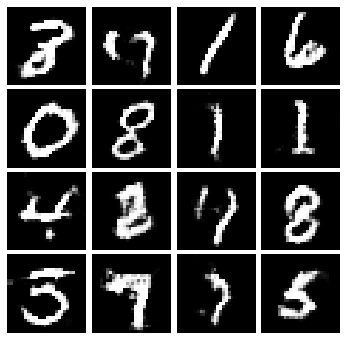

epoch=18, iteration=67501, WD=8.485099792480469, D_loss=-2.26279878616333, G_loss=-98.28646850585938
epoch=18, iteration=67601, WD=22.850862503051758, D_loss=-16.39254379272461, G_loss=-16.740497589111328
epoch=18, iteration=67701, WD=9.428040504455566, D_loss=-4.26104736328125, G_loss=-11.595514297485352
epoch=18, iteration=67801, WD=5.17352294921875, D_loss=0.7554864883422852, G_loss=-33.57719802856445
epoch=18, iteration=67901, WD=11.900749206542969, D_loss=-6.9499125480651855, G_loss=13.585387229919434
epoch=18, iteration=68001, WD=20.082275390625, D_loss=-15.39275074005127, G_loss=-4.179883003234863
epoch=18, iteration=68101, WD=11.37985610961914, D_loss=-5.839391708374023, G_loss=38.51921081542969
epoch=18, iteration=68201, WD=16.924747467041016, D_loss=-11.035262107849121, G_loss=62.247474670410156
epoch=18, iteration=68301, WD=17.713882446289062, D_loss=-11.836461067199707, G_loss=64.85418701171875
epoch=18, iteration=68401, WD=21.761199951171875, D_loss=-16.15264129638672, G_l

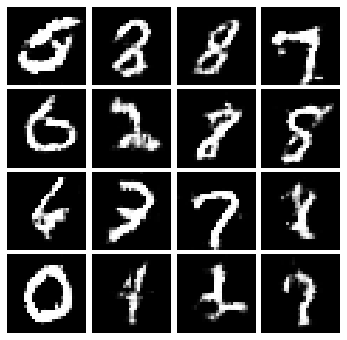

epoch=19, iteration=71301, WD=13.269279479980469, D_loss=-8.102553367614746, G_loss=-5.816551208496094
epoch=19, iteration=71401, WD=15.811359405517578, D_loss=-10.633003234863281, G_loss=15.107519149780273
epoch=19, iteration=71501, WD=7.171558380126953, D_loss=-0.2591085433959961, G_loss=-45.0151252746582
epoch=19, iteration=71601, WD=15.860298156738281, D_loss=-10.642794609069824, G_loss=-33.39228057861328
epoch=19, iteration=71701, WD=4.4730000495910645, D_loss=0.9724631309509277, G_loss=-1.7495931386947632
epoch=19, iteration=71801, WD=8.02582836151123, D_loss=-2.520071506500244, G_loss=18.3795166015625
epoch=19, iteration=71901, WD=15.605459213256836, D_loss=-9.75780200958252, G_loss=28.606285095214844
epoch=19, iteration=72001, WD=9.909381866455078, D_loss=-4.721482276916504, G_loss=-5.810445785522461
epoch=19, iteration=72101, WD=5.25244140625, D_loss=0.24635982513427734, G_loss=-29.124948501586914
epoch=19, iteration=72201, WD=4.6798248291015625, D_loss=0.5512771606445312, G_l

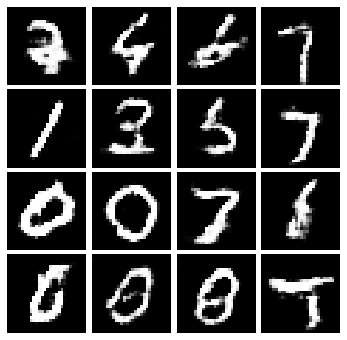

epoch=20, iteration=75001, WD=16.777652740478516, D_loss=-11.670654296875, G_loss=-37.74627685546875
epoch=20, iteration=75101, WD=21.663896560668945, D_loss=-15.678990364074707, G_loss=-5.294368267059326
epoch=20, iteration=75201, WD=12.13508129119873, D_loss=-6.870611190795898, G_loss=33.4643440246582
epoch=20, iteration=75301, WD=6.271045684814453, D_loss=-1.5355620384216309, G_loss=-8.905254364013672
epoch=20, iteration=75401, WD=22.06079864501953, D_loss=-16.3540096282959, G_loss=-75.39690399169922
epoch=20, iteration=75501, WD=23.51424789428711, D_loss=-17.86532211303711, G_loss=53.94089889526367
epoch=20, iteration=75601, WD=17.85610580444336, D_loss=-12.635473251342773, G_loss=34.881412506103516
epoch=20, iteration=75701, WD=15.863704681396484, D_loss=-10.6471529006958, G_loss=-20.13401222229004
epoch=20, iteration=75801, WD=7.600090026855469, D_loss=-2.974386692047119, G_loss=-54.983299255371094
epoch=20, iteration=75901, WD=0.39899444580078125, D_loss=5.585077285766602, G_los

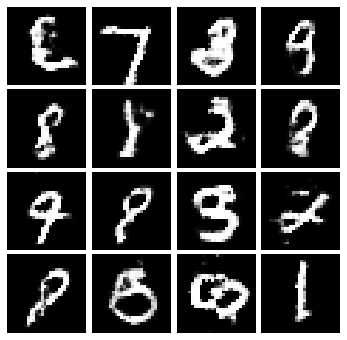

epoch=21, iteration=78801, WD=9.474401473999023, D_loss=-3.8794989585876465, G_loss=-20.83698081970215
epoch=21, iteration=78901, WD=17.352497100830078, D_loss=-11.535778045654297, G_loss=-2.351141929626465
epoch=21, iteration=79001, WD=21.1641845703125, D_loss=-15.188203811645508, G_loss=25.491697311401367
epoch=21, iteration=79101, WD=16.4905948638916, D_loss=-9.777791023254395, G_loss=34.5655403137207
epoch=21, iteration=79201, WD=18.178756713867188, D_loss=-13.196582794189453, G_loss=-13.099215507507324
epoch=21, iteration=79301, WD=12.943782806396484, D_loss=-7.694874286651611, G_loss=-62.05399703979492
epoch=21, iteration=79401, WD=8.532978057861328, D_loss=-2.9158973693847656, G_loss=16.1551456451416
epoch=21, iteration=79501, WD=18.77014923095703, D_loss=-12.966047286987305, G_loss=-49.6487922668457
epoch=21, iteration=79601, WD=4.470616817474365, D_loss=1.4591484069824219, G_loss=7.073156356811523
epoch=21, iteration=79701, WD=22.42064666748047, D_loss=-17.37543296813965, G_lo

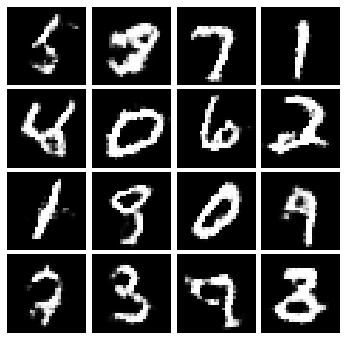

epoch=22, iteration=82501, WD=10.69034194946289, D_loss=-4.842716693878174, G_loss=67.75733184814453
epoch=22, iteration=82601, WD=-1.4159088134765625, D_loss=7.182924747467041, G_loss=-2.6909852027893066
epoch=22, iteration=82701, WD=3.967514991760254, D_loss=0.8982510566711426, G_loss=-17.66574478149414
epoch=22, iteration=82801, WD=-3.1303348541259766, D_loss=8.342952728271484, G_loss=25.444576263427734
epoch=22, iteration=82901, WD=10.944303512573242, D_loss=-5.977208137512207, G_loss=-31.715620040893555
epoch=22, iteration=83001, WD=4.2676191329956055, D_loss=1.0236921310424805, G_loss=-2.233938217163086
epoch=22, iteration=83101, WD=14.530109405517578, D_loss=-8.736156463623047, G_loss=53.08119583129883
epoch=22, iteration=83201, WD=10.078784942626953, D_loss=-4.285604953765869, G_loss=49.1708984375
epoch=22, iteration=83301, WD=11.650054931640625, D_loss=-4.894895553588867, G_loss=128.13670349121094
epoch=22, iteration=83401, WD=15.486572265625, D_loss=-10.051334381103516, G_los

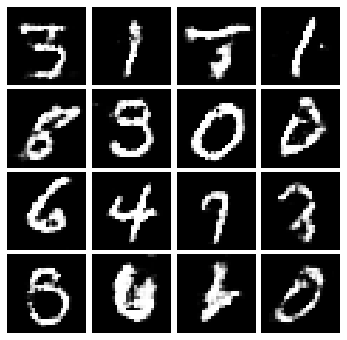

epoch=23, iteration=86301, WD=15.61900520324707, D_loss=-10.353275299072266, G_loss=20.087749481201172
epoch=23, iteration=86401, WD=10.736502647399902, D_loss=-5.794754981994629, G_loss=5.792917251586914
epoch=23, iteration=86501, WD=5.161033630371094, D_loss=1.3353052139282227, G_loss=-83.53055572509766
epoch=23, iteration=86601, WD=5.79099178314209, D_loss=-0.815758228302002, G_loss=-8.377863883972168
epoch=23, iteration=86701, WD=6.398345947265625, D_loss=-1.1412115097045898, G_loss=-68.40988159179688
epoch=23, iteration=86801, WD=1.6963119506835938, D_loss=3.9996795654296875, G_loss=-67.83909606933594
epoch=23, iteration=86901, WD=12.511506080627441, D_loss=-7.012200355529785, G_loss=-1.4395400285720825
epoch=23, iteration=87001, WD=25.664737701416016, D_loss=-19.139883041381836, G_loss=59.7114143371582
epoch=23, iteration=87101, WD=9.558883666992188, D_loss=-2.8725290298461914, G_loss=94.7643051147461
epoch=23, iteration=87201, WD=14.878625869750977, D_loss=-9.417574882507324, G_

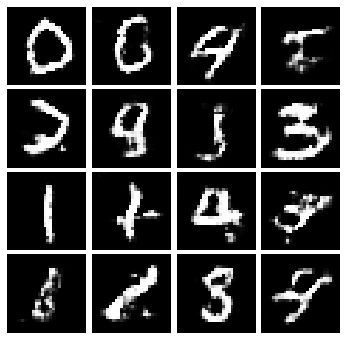

epoch=24, iteration=90001, WD=19.414306640625, D_loss=-13.551770210266113, G_loss=-45.19081497192383
epoch=24, iteration=90101, WD=9.09351921081543, D_loss=-3.6077146530151367, G_loss=18.141155242919922
epoch=24, iteration=90201, WD=11.61727523803711, D_loss=-4.089760780334473, G_loss=29.13593292236328
epoch=24, iteration=90301, WD=7.596458435058594, D_loss=-2.0318832397460938, G_loss=55.96806335449219
epoch=24, iteration=90401, WD=19.101959228515625, D_loss=-13.072271347045898, G_loss=65.93025970458984
epoch=24, iteration=90501, WD=14.445980072021484, D_loss=-8.937663078308105, G_loss=49.3851318359375
epoch=24, iteration=90601, WD=2.0602455139160156, D_loss=3.8451452255249023, G_loss=33.03532791137695
epoch=24, iteration=90701, WD=16.17278289794922, D_loss=-11.811991691589355, G_loss=-73.45133209228516
epoch=24, iteration=90801, WD=7.597553253173828, D_loss=-2.1705217361450195, G_loss=-60.34974670410156
epoch=24, iteration=90901, WD=6.135227203369141, D_loss=-0.9313335418701172, G_los

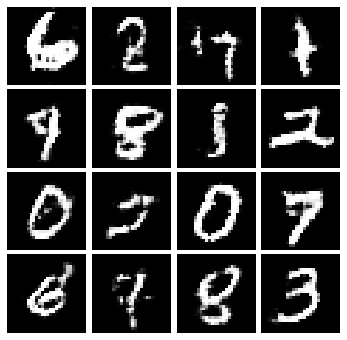

epoch=25, iteration=93801, WD=-5.987895965576172, D_loss=11.934751510620117, G_loss=-31.467269897460938
epoch=25, iteration=93901, WD=11.062398910522461, D_loss=-6.5119829177856445, G_loss=-17.923664093017578
epoch=25, iteration=94001, WD=6.4560546875, D_loss=-1.3683905601501465, G_loss=-29.860164642333984
epoch=25, iteration=94101, WD=8.321372985839844, D_loss=-2.722341537475586, G_loss=-47.95294189453125
epoch=25, iteration=94201, WD=11.770195007324219, D_loss=-5.672948837280273, G_loss=-67.6185531616211
epoch=25, iteration=94301, WD=17.170867919921875, D_loss=-11.705116271972656, G_loss=-90.44426727294922
epoch=25, iteration=94401, WD=4.234958648681641, D_loss=2.320657730102539, G_loss=-25.693248748779297
epoch=25, iteration=94501, WD=31.960472106933594, D_loss=-26.357227325439453, G_loss=-47.56057357788086
epoch=25, iteration=94601, WD=9.071486473083496, D_loss=-2.516629219055176, G_loss=-32.13197708129883
epoch=25, iteration=94701, WD=1.9692230224609375, D_loss=3.501716136932373, 

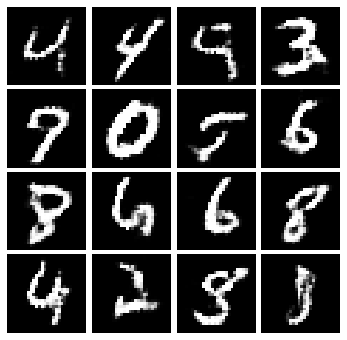

epoch=26, iteration=97501, WD=19.221393585205078, D_loss=-13.240474700927734, G_loss=-45.701419830322266
epoch=26, iteration=97601, WD=27.98507308959961, D_loss=-22.937440872192383, G_loss=-1.1315431594848633
epoch=26, iteration=97701, WD=8.08990478515625, D_loss=-2.269191265106201, G_loss=-77.65288543701172
epoch=26, iteration=97801, WD=13.920467376708984, D_loss=-8.400995254516602, G_loss=-21.91587257385254
epoch=26, iteration=97901, WD=11.383708953857422, D_loss=-7.371418476104736, G_loss=-23.261751174926758
epoch=26, iteration=98001, WD=18.416584014892578, D_loss=-13.239605903625488, G_loss=-51.951839447021484
epoch=26, iteration=98101, WD=1.0615730285644531, D_loss=3.894009590148926, G_loss=-48.27690124511719
epoch=26, iteration=98201, WD=7.797762870788574, D_loss=-2.017915725708008, G_loss=15.924129486083984
epoch=26, iteration=98301, WD=0.15114593505859375, D_loss=4.744357109069824, G_loss=-62.31631088256836
epoch=26, iteration=98401, WD=5.494374752044678, D_loss=-0.208065032958

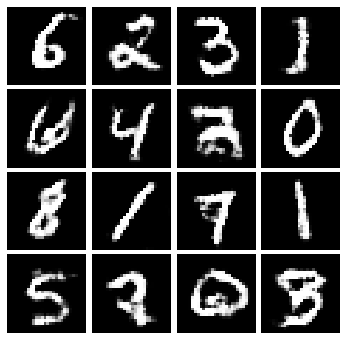

epoch=27, iteration=101301, WD=16.722827911376953, D_loss=-11.221908569335938, G_loss=-61.71981430053711
epoch=27, iteration=101401, WD=22.695175170898438, D_loss=-17.484649658203125, G_loss=-74.43090057373047
epoch=27, iteration=101501, WD=4.781362533569336, D_loss=1.059079647064209, G_loss=-2.1249148845672607
epoch=27, iteration=101601, WD=20.947532653808594, D_loss=-15.607927322387695, G_loss=-18.59564208984375
epoch=27, iteration=101701, WD=2.595355987548828, D_loss=2.3334860801696777, G_loss=43.65041732788086
epoch=27, iteration=101801, WD=6.205310821533203, D_loss=-0.2701072692871094, G_loss=41.648109436035156
epoch=27, iteration=101901, WD=8.70821762084961, D_loss=-3.782029151916504, G_loss=65.23114013671875
epoch=27, iteration=102001, WD=6.176872253417969, D_loss=-1.8120946884155273, G_loss=-51.88318634033203
epoch=27, iteration=102101, WD=2.0762462615966797, D_loss=3.0611696243286133, G_loss=-1.0990755558013916
epoch=27, iteration=102201, WD=13.753972053527832, D_loss=-7.93713

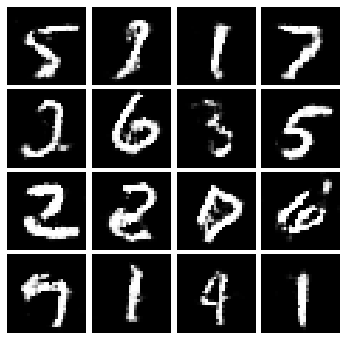

epoch=28, iteration=105001, WD=14.404455184936523, D_loss=-9.737874031066895, G_loss=-24.032684326171875
epoch=28, iteration=105101, WD=8.500204086303711, D_loss=-3.051558017730713, G_loss=-20.12508773803711
epoch=28, iteration=105201, WD=8.014888763427734, D_loss=-3.5156211853027344, G_loss=-66.88876342773438
epoch=28, iteration=105301, WD=6.277011871337891, D_loss=-1.024043083190918, G_loss=-28.923805236816406
epoch=28, iteration=105401, WD=6.238494873046875, D_loss=-1.1078519821166992, G_loss=-50.677330017089844
epoch=28, iteration=105501, WD=20.063129425048828, D_loss=-14.86199951171875, G_loss=-60.292415618896484
epoch=28, iteration=105601, WD=6.0460357666015625, D_loss=-0.41303014755249023, G_loss=-63.73519515991211
epoch=28, iteration=105701, WD=7.716197967529297, D_loss=-3.1015372276306152, G_loss=-54.416526794433594
epoch=28, iteration=105801, WD=3.5920534133911133, D_loss=1.4760174751281738, G_loss=16.413393020629883
epoch=28, iteration=105901, WD=12.939678192138672, D_loss=-

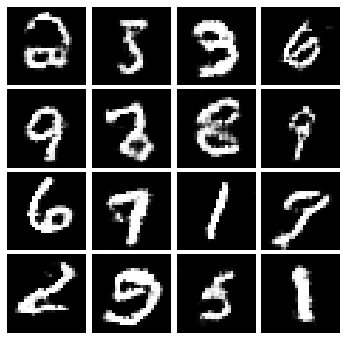

epoch=29, iteration=108801, WD=13.345478057861328, D_loss=-8.188590049743652, G_loss=-39.191612243652344
epoch=29, iteration=108901, WD=7.914863586425781, D_loss=-2.4287829399108887, G_loss=-51.018428802490234
epoch=29, iteration=109001, WD=14.688623428344727, D_loss=-9.2877779006958, G_loss=28.987810134887695
epoch=29, iteration=109101, WD=23.341529846191406, D_loss=-18.226776123046875, G_loss=43.59025955200195
epoch=29, iteration=109201, WD=-0.6498661041259766, D_loss=6.048361301422119, G_loss=-16.07746696472168
epoch=29, iteration=109301, WD=6.863315582275391, D_loss=-1.8175387382507324, G_loss=-39.96352767944336
epoch=29, iteration=109401, WD=15.251483917236328, D_loss=-10.153203010559082, G_loss=-52.29326248168945
epoch=29, iteration=109501, WD=-14.524444580078125, D_loss=19.75029754638672, G_loss=33.20282745361328
epoch=29, iteration=109601, WD=3.231447219848633, D_loss=1.8940129280090332, G_loss=23.31136131286621
epoch=29, iteration=109701, WD=2.0009756088256836, D_loss=3.491901

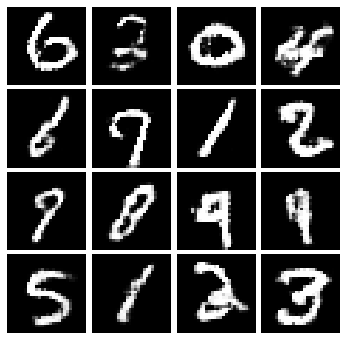

epoch=30, iteration=112501, WD=-1.0470085144042969, D_loss=5.971303939819336, G_loss=-46.30118179321289
epoch=30, iteration=112601, WD=17.49575424194336, D_loss=-12.97195816040039, G_loss=-48.56667709350586
epoch=30, iteration=112701, WD=14.570514678955078, D_loss=-8.292057037353516, G_loss=-59.5316276550293
epoch=30, iteration=112801, WD=4.70477294921875, D_loss=0.9322247505187988, G_loss=-16.3110294342041
epoch=30, iteration=112901, WD=0.6832847595214844, D_loss=5.162662982940674, G_loss=62.893951416015625
epoch=30, iteration=113001, WD=8.173606872558594, D_loss=-2.80879545211792, G_loss=24.912813186645508
epoch=30, iteration=113101, WD=9.401815414428711, D_loss=-4.030365943908691, G_loss=42.094783782958984
epoch=30, iteration=113201, WD=9.665132522583008, D_loss=-4.48740816116333, G_loss=-2.3570234775543213
epoch=30, iteration=113301, WD=11.166282653808594, D_loss=-5.894285678863525, G_loss=-31.737642288208008
epoch=30, iteration=113401, WD=4.514457702636719, D_loss=1.08202314376831

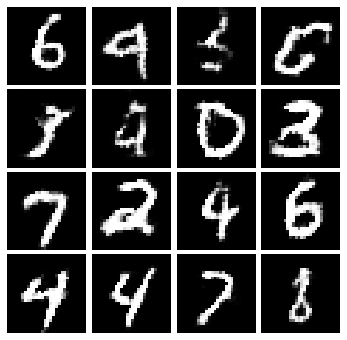

epoch=31, iteration=116301, WD=14.627498626708984, D_loss=-9.742452621459961, G_loss=56.280303955078125
epoch=31, iteration=116401, WD=6.19672966003418, D_loss=-1.989586353302002, G_loss=-25.067312240600586
epoch=31, iteration=116501, WD=4.861846923828125, D_loss=-0.14928388595581055, G_loss=-72.55618286132812
epoch=31, iteration=116601, WD=-1.4779467582702637, D_loss=5.7694993019104, G_loss=-7.968408584594727
epoch=31, iteration=116701, WD=-10.88540267944336, D_loss=17.094623565673828, G_loss=66.60308837890625
epoch=31, iteration=116801, WD=6.244968414306641, D_loss=-1.6019349098205566, G_loss=-20.14645767211914
epoch=31, iteration=116901, WD=-4.1448974609375, D_loss=8.758447647094727, G_loss=-82.89993286132812
epoch=31, iteration=117001, WD=6.369087219238281, D_loss=-1.8047890663146973, G_loss=31.902137756347656
epoch=31, iteration=117101, WD=19.464054107666016, D_loss=-14.722769737243652, G_loss=15.938207626342773
epoch=31, iteration=117201, WD=4.949993133544922, D_loss=-1.052457571

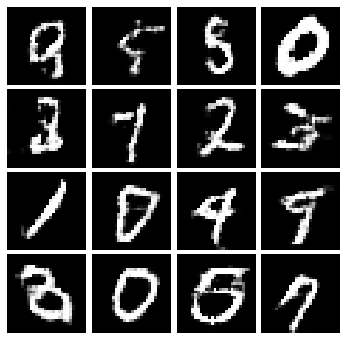

epoch=32, iteration=120001, WD=6.796222686767578, D_loss=-2.3546624183654785, G_loss=-33.8768196105957
epoch=32, iteration=120101, WD=13.852294921875, D_loss=-8.981945037841797, G_loss=-14.078173637390137
epoch=32, iteration=120201, WD=-1.3433971405029297, D_loss=6.311163425445557, G_loss=-19.074853897094727
epoch=32, iteration=120301, WD=-1.3041725158691406, D_loss=5.939114093780518, G_loss=-34.66689682006836
epoch=32, iteration=120401, WD=16.418670654296875, D_loss=-11.327285766601562, G_loss=-76.5819320678711
epoch=32, iteration=120501, WD=9.788108825683594, D_loss=-4.57867431640625, G_loss=-71.70124816894531
epoch=32, iteration=120601, WD=9.491756439208984, D_loss=-4.853739261627197, G_loss=-39.643070220947266
epoch=32, iteration=120701, WD=7.1194539070129395, D_loss=-2.429020881652832, G_loss=8.650199890136719
epoch=32, iteration=120801, WD=2.8035202026367188, D_loss=1.9788122177124023, G_loss=-48.85884094238281
epoch=32, iteration=120901, WD=1.3508291244506836, D_loss=3.066369056

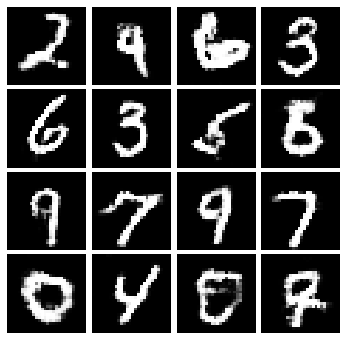

epoch=33, iteration=123801, WD=4.245109558105469, D_loss=0.6237525939941406, G_loss=17.882923126220703
epoch=33, iteration=123901, WD=5.049282073974609, D_loss=0.3070540428161621, G_loss=67.1390151977539
epoch=33, iteration=124001, WD=0.8400449752807617, D_loss=3.6208882331848145, G_loss=15.285659790039062
epoch=33, iteration=124101, WD=5.557579040527344, D_loss=-1.180398941040039, G_loss=-24.41819953918457
epoch=33, iteration=124201, WD=9.907341003417969, D_loss=-4.710198402404785, G_loss=-105.99766540527344
epoch=33, iteration=124301, WD=9.177242279052734, D_loss=-4.0674848556518555, G_loss=-31.48675537109375
epoch=33, iteration=124401, WD=5.848701477050781, D_loss=-1.1610116958618164, G_loss=30.01385498046875
epoch=33, iteration=124501, WD=5.544975280761719, D_loss=-0.6425714492797852, G_loss=63.6360969543457
epoch=33, iteration=124601, WD=17.70383071899414, D_loss=-13.925041198730469, G_loss=-43.363380432128906
epoch=33, iteration=124701, WD=9.675033569335938, D_loss=-5.38357591629

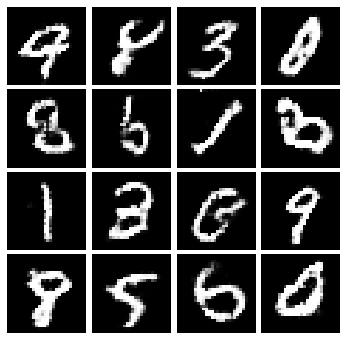

epoch=34, iteration=127501, WD=-6.189996719360352, D_loss=10.784257888793945, G_loss=22.665355682373047
epoch=34, iteration=127601, WD=14.612503051757812, D_loss=-10.247629165649414, G_loss=-8.244935989379883
epoch=34, iteration=127701, WD=8.048931121826172, D_loss=-3.201007843017578, G_loss=-56.69111251831055
epoch=34, iteration=127801, WD=13.365335464477539, D_loss=-8.91606616973877, G_loss=6.6032867431640625
epoch=34, iteration=127901, WD=11.312824249267578, D_loss=-6.538766860961914, G_loss=38.62595748901367
epoch=34, iteration=128001, WD=7.722158432006836, D_loss=-3.476700782775879, G_loss=23.141456604003906
epoch=34, iteration=128101, WD=15.070022583007812, D_loss=-10.317171096801758, G_loss=23.593366622924805
epoch=34, iteration=128201, WD=-3.010162591934204, D_loss=7.955320358276367, G_loss=15.480547904968262
epoch=34, iteration=128301, WD=0.13570022583007812, D_loss=4.53776216506958, G_loss=-38.68806457519531
epoch=34, iteration=128401, WD=22.215301513671875, D_loss=-17.272983

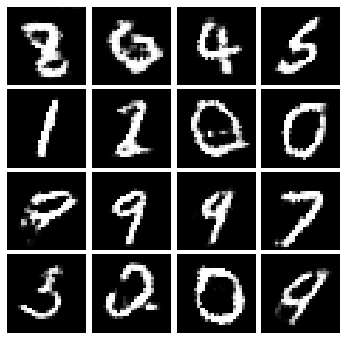

epoch=35, iteration=131301, WD=8.265840530395508, D_loss=-3.7476296424865723, G_loss=-16.34827423095703
epoch=35, iteration=131401, WD=8.749786376953125, D_loss=-4.8722991943359375, G_loss=6.471475601196289
epoch=35, iteration=131501, WD=13.946136474609375, D_loss=-9.299277305603027, G_loss=37.70732498168945
epoch=35, iteration=131601, WD=11.65187931060791, D_loss=-6.65818977355957, G_loss=16.077072143554688
epoch=35, iteration=131701, WD=14.259557723999023, D_loss=-9.300209045410156, G_loss=27.76324462890625
epoch=35, iteration=131801, WD=1.30718994140625, D_loss=3.2511677742004395, G_loss=-113.15625762939453
epoch=35, iteration=131901, WD=6.530120849609375, D_loss=-2.512784004211426, G_loss=-50.72267532348633
epoch=35, iteration=132001, WD=12.649410247802734, D_loss=-6.241102695465088, G_loss=57.5530891418457
epoch=35, iteration=132101, WD=1.8104743957519531, D_loss=2.1851840019226074, G_loss=-5.356576919555664
epoch=35, iteration=132201, WD=5.433794021606445, D_loss=-1.4716947078704

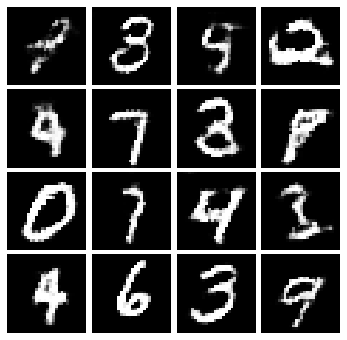

epoch=36, iteration=135001, WD=7.3149237632751465, D_loss=-3.3863210678100586, G_loss=8.968423843383789
epoch=36, iteration=135101, WD=11.502349853515625, D_loss=-7.501492500305176, G_loss=-39.75459289550781
epoch=36, iteration=135201, WD=18.72686767578125, D_loss=-14.630057334899902, G_loss=-22.44353675842285
epoch=36, iteration=135301, WD=18.001876831054688, D_loss=-13.622119903564453, G_loss=-57.60686111450195
epoch=36, iteration=135401, WD=7.519590854644775, D_loss=-3.406942844390869, G_loss=-7.641465187072754
epoch=36, iteration=135501, WD=14.902034759521484, D_loss=-10.933595657348633, G_loss=0.038765549659729004
epoch=36, iteration=135601, WD=17.111557006835938, D_loss=-12.784961700439453, G_loss=-14.835474014282227
epoch=36, iteration=135701, WD=2.469137191772461, D_loss=3.6259474754333496, G_loss=-21.341535568237305
epoch=36, iteration=135801, WD=7.350072860717773, D_loss=-2.15817928314209, G_loss=-13.232101440429688
epoch=36, iteration=135901, WD=24.953792572021484, D_loss=-2

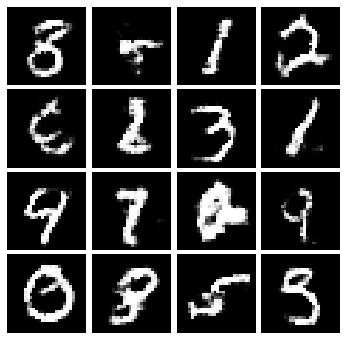

epoch=37, iteration=138801, WD=9.829023361206055, D_loss=-4.91358757019043, G_loss=1.2190654277801514
epoch=37, iteration=138901, WD=4.675712585449219, D_loss=-0.6243696212768555, G_loss=-35.216556549072266
epoch=37, iteration=139001, WD=-5.665389537811279, D_loss=10.434348106384277, G_loss=-1.4712269306182861
epoch=37, iteration=139101, WD=6.691764831542969, D_loss=-0.9523067474365234, G_loss=61.043251037597656
epoch=37, iteration=139201, WD=16.738676071166992, D_loss=-12.633478164672852, G_loss=1.4109973907470703
epoch=37, iteration=139301, WD=19.203495025634766, D_loss=-14.283308029174805, G_loss=-56.92889404296875
epoch=37, iteration=139401, WD=12.948638916015625, D_loss=-8.85495376586914, G_loss=-56.11054992675781
epoch=37, iteration=139501, WD=1.2276954650878906, D_loss=2.6920151710510254, G_loss=-40.3617057800293
epoch=37, iteration=139601, WD=9.414899826049805, D_loss=-5.102341651916504, G_loss=-30.661075592041016
epoch=37, iteration=139701, WD=1.065826416015625, D_loss=3.21056

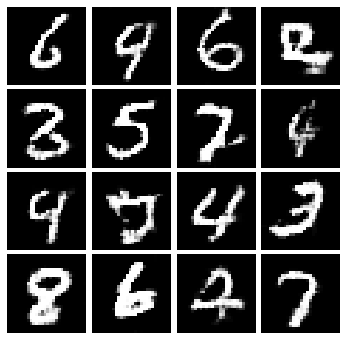

epoch=38, iteration=142501, WD=6.660482406616211, D_loss=-2.3912487030029297, G_loss=17.05572509765625
epoch=38, iteration=142601, WD=4.898160934448242, D_loss=-1.0927743911743164, G_loss=-23.977075576782227
epoch=38, iteration=142701, WD=28.321624755859375, D_loss=-23.712505340576172, G_loss=-92.5411148071289
epoch=38, iteration=142801, WD=12.63638973236084, D_loss=-7.0869975090026855, G_loss=10.3908052444458
epoch=38, iteration=142901, WD=19.77596664428711, D_loss=-15.36986255645752, G_loss=-29.206411361694336
epoch=38, iteration=143001, WD=8.746098518371582, D_loss=-4.837886810302734, G_loss=-15.832091331481934
epoch=38, iteration=143101, WD=17.72228240966797, D_loss=-13.652703285217285, G_loss=0.31496402621269226
epoch=38, iteration=143201, WD=3.3614501953125, D_loss=1.3170270919799805, G_loss=-26.828365325927734
epoch=38, iteration=143301, WD=4.744271278381348, D_loss=-0.3510708808898926, G_loss=-9.588785171508789
epoch=38, iteration=143401, WD=10.265924453735352, D_loss=-6.281940

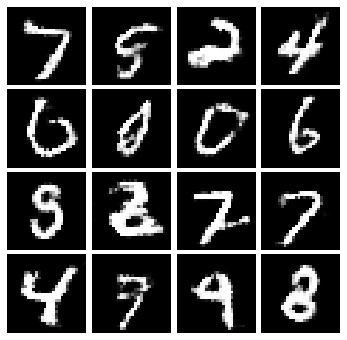

epoch=39, iteration=146301, WD=-1.199005126953125, D_loss=6.051651477813721, G_loss=-21.599918365478516
epoch=39, iteration=146401, WD=7.52679443359375, D_loss=-2.8669681549072266, G_loss=-49.6445426940918
epoch=39, iteration=146501, WD=13.112060546875, D_loss=-8.00219440460205, G_loss=-76.16839599609375
epoch=39, iteration=146601, WD=-3.7383415699005127, D_loss=8.225157737731934, G_loss=3.2054123878479004
epoch=39, iteration=146701, WD=26.408226013183594, D_loss=-21.668903350830078, G_loss=59.55350112915039
epoch=39, iteration=146801, WD=9.70888900756836, D_loss=-5.2872514724731445, G_loss=-36.66053771972656
epoch=39, iteration=146901, WD=35.77782440185547, D_loss=-29.070953369140625, G_loss=-91.00125885009766
epoch=39, iteration=147001, WD=4.764286041259766, D_loss=-0.7846996784210205, G_loss=26.62710189819336
epoch=39, iteration=147101, WD=15.719043731689453, D_loss=-11.14270305633545, G_loss=55.51716995239258
epoch=39, iteration=147201, WD=6.247760772705078, D_loss=-2.2149691581726

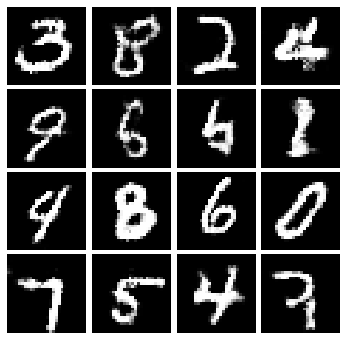

epoch=40, iteration=150001, WD=5.519845962524414, D_loss=-0.9482569694519043, G_loss=-15.650763511657715
epoch=40, iteration=150101, WD=15.622968673706055, D_loss=-10.959144592285156, G_loss=-21.39444351196289
epoch=40, iteration=150201, WD=11.354307174682617, D_loss=-7.249549388885498, G_loss=8.337919235229492
epoch=40, iteration=150301, WD=12.739391326904297, D_loss=-8.00822639465332, G_loss=-40.293087005615234
epoch=40, iteration=150401, WD=17.161731719970703, D_loss=-12.376762390136719, G_loss=-43.15848159790039
epoch=40, iteration=150501, WD=16.89063262939453, D_loss=-11.657061576843262, G_loss=6.734984397888184
epoch=40, iteration=150601, WD=3.6106185913085938, D_loss=1.1222424507141113, G_loss=57.41119384765625
epoch=40, iteration=150701, WD=5.2328948974609375, D_loss=-0.7752246856689453, G_loss=-63.75558090209961
epoch=40, iteration=150801, WD=-0.3767127990722656, D_loss=5.099503517150879, G_loss=-30.495147705078125
epoch=40, iteration=150901, WD=-6.299210071563721, D_loss=10.4

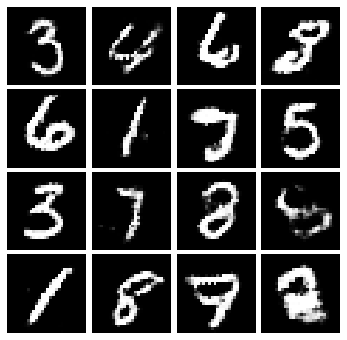

epoch=41, iteration=153801, WD=8.744139671325684, D_loss=-4.764342308044434, G_loss=31.45903205871582
epoch=41, iteration=153901, WD=1.141845703125, D_loss=3.1225242614746094, G_loss=-52.16923522949219
epoch=41, iteration=154001, WD=11.842620849609375, D_loss=-7.146841526031494, G_loss=-64.35812377929688
epoch=41, iteration=154101, WD=7.557582855224609, D_loss=-3.3989663124084473, G_loss=-18.124563217163086
epoch=41, iteration=154201, WD=22.29473304748535, D_loss=-17.86817169189453, G_loss=24.55950355529785
epoch=41, iteration=154301, WD=-15.235645294189453, D_loss=19.82705307006836, G_loss=-49.86347198486328
epoch=41, iteration=154401, WD=1.514556884765625, D_loss=3.210207462310791, G_loss=-56.37260437011719
epoch=41, iteration=154501, WD=-11.156609535217285, D_loss=15.49948501586914, G_loss=-14.174016952514648
epoch=41, iteration=154601, WD=15.534618377685547, D_loss=-10.517865180969238, G_loss=27.783384323120117
epoch=41, iteration=154701, WD=16.78984832763672, D_loss=-12.2617244720

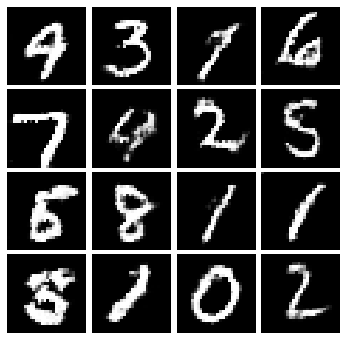

epoch=42, iteration=157501, WD=12.564603805541992, D_loss=-8.812952041625977, G_loss=30.510940551757812
epoch=42, iteration=157601, WD=7.866519927978516, D_loss=-4.210514068603516, G_loss=-0.9372066259384155
epoch=42, iteration=157701, WD=14.343204498291016, D_loss=-9.897235870361328, G_loss=-50.2805061340332
epoch=42, iteration=157801, WD=27.753982543945312, D_loss=-22.894649505615234, G_loss=-79.9854965209961
epoch=42, iteration=157901, WD=11.837013244628906, D_loss=-6.987026691436768, G_loss=44.49803161621094
epoch=42, iteration=158001, WD=5.333673477172852, D_loss=-1.7812485694885254, G_loss=-17.948518753051758
epoch=42, iteration=158101, WD=5.3411407470703125, D_loss=-1.8397257328033447, G_loss=-53.32191848754883
epoch=42, iteration=158201, WD=3.9801511764526367, D_loss=0.40562915802001953, G_loss=-3.645199775695801
epoch=42, iteration=158301, WD=5.366193771362305, D_loss=-1.832080364227295, G_loss=-22.597373962402344
epoch=42, iteration=158401, WD=7.350774765014648, D_loss=-3.220

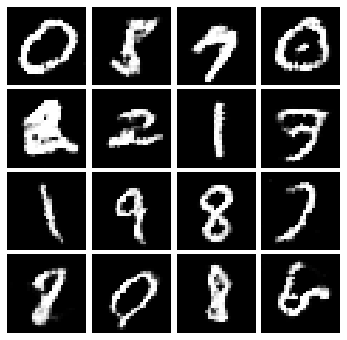

epoch=43, iteration=161301, WD=10.334966659545898, D_loss=-6.538642406463623, G_loss=-11.100858688354492
epoch=43, iteration=161401, WD=0.279754638671875, D_loss=3.739210605621338, G_loss=-50.179195404052734
epoch=43, iteration=161501, WD=4.505645751953125, D_loss=0.11481094360351562, G_loss=-71.43141174316406
epoch=43, iteration=161601, WD=6.08888053894043, D_loss=-1.745375156402588, G_loss=-30.419719696044922
epoch=43, iteration=161701, WD=7.671710014343262, D_loss=-3.5922889709472656, G_loss=-9.493946075439453
epoch=43, iteration=161801, WD=0.7586860656738281, D_loss=3.272752285003662, G_loss=-15.759588241577148
epoch=43, iteration=161901, WD=0.8543319702148438, D_loss=3.272195816040039, G_loss=-71.202392578125
epoch=43, iteration=162001, WD=6.898296356201172, D_loss=-3.345097541809082, G_loss=-28.96014976501465
epoch=43, iteration=162101, WD=10.491698265075684, D_loss=-6.58134651184082, G_loss=6.514468193054199
epoch=43, iteration=162201, WD=8.12343978881836, D_loss=-4.074694633483

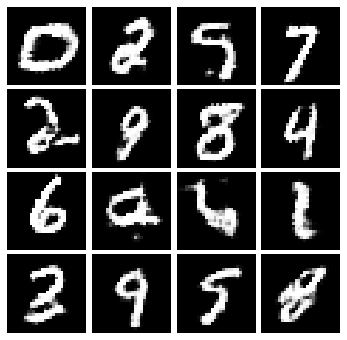

epoch=44, iteration=165001, WD=4.306673526763916, D_loss=0.27237749099731445, G_loss=11.115221977233887
epoch=44, iteration=165101, WD=6.530235290527344, D_loss=-1.8432741165161133, G_loss=-77.47994232177734
epoch=44, iteration=165201, WD=13.791098594665527, D_loss=-9.700091361999512, G_loss=17.635269165039062
epoch=44, iteration=165301, WD=8.852741241455078, D_loss=-4.859137535095215, G_loss=-21.791019439697266
epoch=44, iteration=165401, WD=17.35986328125, D_loss=-12.918364524841309, G_loss=-51.56714630126953
epoch=44, iteration=165501, WD=3.84716796875, D_loss=0.18125343322753906, G_loss=20.559993743896484
epoch=44, iteration=165601, WD=7.458065032958984, D_loss=-3.3461461067199707, G_loss=-59.78655242919922
epoch=44, iteration=165701, WD=4.365006446838379, D_loss=-0.422684907913208, G_loss=-13.562515258789062
epoch=44, iteration=165801, WD=-0.8548355102539062, D_loss=5.190655708312988, G_loss=37.81117248535156
epoch=44, iteration=165901, WD=23.60619354248047, D_loss=-19.81996917724

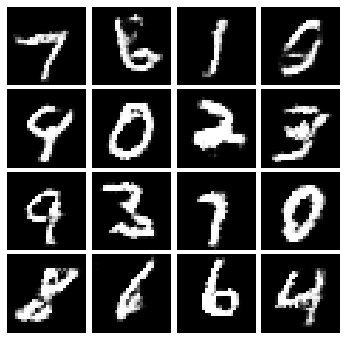

epoch=45, iteration=168801, WD=16.236038208007812, D_loss=-12.525740623474121, G_loss=-52.00190353393555
epoch=45, iteration=168901, WD=9.955442428588867, D_loss=-6.018198013305664, G_loss=3.888174057006836
epoch=45, iteration=169001, WD=13.612560272216797, D_loss=-8.877298355102539, G_loss=-3.7576329708099365
epoch=45, iteration=169101, WD=4.863658905029297, D_loss=-0.9794068336486816, G_loss=-28.306461334228516
epoch=45, iteration=169201, WD=3.5317420959472656, D_loss=0.13569116592407227, G_loss=-12.139725685119629
epoch=45, iteration=169301, WD=4.127239227294922, D_loss=-0.4905662536621094, G_loss=-2.6536524295806885
epoch=45, iteration=169401, WD=3.6182785034179688, D_loss=0.4855337142944336, G_loss=-34.61331558227539
epoch=45, iteration=169501, WD=4.765937805175781, D_loss=-0.668177604675293, G_loss=-65.10279846191406
epoch=45, iteration=169601, WD=3.2619705200195312, D_loss=0.4916269779205322, G_loss=-32.97245407104492
epoch=45, iteration=169701, WD=23.537324905395508, D_loss=-19

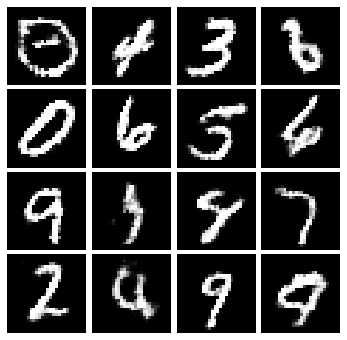

epoch=46, iteration=172501, WD=2.944580078125, D_loss=1.6059074401855469, G_loss=39.32870864868164
epoch=46, iteration=172601, WD=6.956066131591797, D_loss=-2.84195613861084, G_loss=-55.3358154296875
epoch=46, iteration=172701, WD=0.6058940887451172, D_loss=3.1884899139404297, G_loss=-30.070934295654297
epoch=46, iteration=172801, WD=17.678112030029297, D_loss=-12.56497859954834, G_loss=16.486770629882812
epoch=46, iteration=172901, WD=-3.2934188842773438, D_loss=8.376612663269043, G_loss=-26.484609603881836
epoch=46, iteration=173001, WD=7.462818145751953, D_loss=-3.5599374771118164, G_loss=-65.64437103271484
epoch=46, iteration=173101, WD=11.328357696533203, D_loss=-7.008780002593994, G_loss=17.035247802734375
epoch=46, iteration=173201, WD=5.667545318603516, D_loss=-1.9773612022399902, G_loss=-53.66279220581055
epoch=46, iteration=173301, WD=-5.684326171875, D_loss=9.96728801727295, G_loss=-63.35697937011719
epoch=46, iteration=173401, WD=-1.2898885011672974, D_loss=5.27288341522216

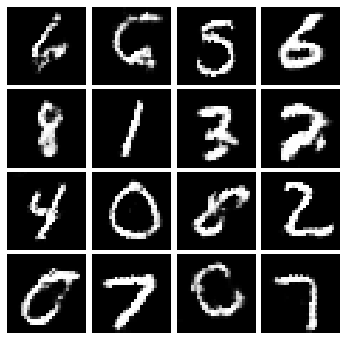

epoch=47, iteration=176301, WD=-9.578800201416016, D_loss=13.551278114318848, G_loss=-48.91240692138672
epoch=47, iteration=176401, WD=7.1940765380859375, D_loss=-3.2937533855438232, G_loss=-44.228702545166016
epoch=47, iteration=176501, WD=5.036998748779297, D_loss=-1.190049648284912, G_loss=16.878902435302734
epoch=47, iteration=176601, WD=4.5358123779296875, D_loss=-0.9285211563110352, G_loss=-66.85578155517578
epoch=47, iteration=176701, WD=9.350364685058594, D_loss=-4.668305397033691, G_loss=-57.87824630737305
epoch=47, iteration=176801, WD=1.218611717224121, D_loss=3.3411951065063477, G_loss=19.2510929107666
epoch=47, iteration=176901, WD=-4.380014419555664, D_loss=8.41606616973877, G_loss=-17.33856201171875
epoch=47, iteration=177001, WD=5.626655578613281, D_loss=-1.2186293601989746, G_loss=-74.98664093017578
epoch=47, iteration=177101, WD=10.144901275634766, D_loss=-6.026124000549316, G_loss=-36.6123046875
epoch=47, iteration=177201, WD=9.647502899169922, D_loss=-5.474409103393

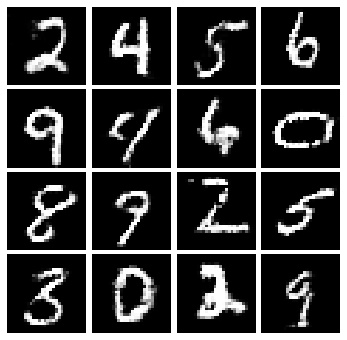

epoch=48, iteration=180001, WD=6.235496520996094, D_loss=-1.9286103248596191, G_loss=-43.79927444458008
epoch=48, iteration=180101, WD=6.453517913818359, D_loss=-2.8096742630004883, G_loss=-34.12351608276367
epoch=48, iteration=180201, WD=0.040737152099609375, D_loss=3.8884174823760986, G_loss=-59.454750061035156
epoch=48, iteration=180301, WD=14.176918029785156, D_loss=-9.942651748657227, G_loss=-57.95035171508789
epoch=48, iteration=180401, WD=16.730323791503906, D_loss=-12.55502986907959, G_loss=-13.038719177246094
epoch=48, iteration=180501, WD=1.573089599609375, D_loss=2.636500358581543, G_loss=-87.2928237915039
epoch=48, iteration=180601, WD=15.805121421813965, D_loss=-11.866752624511719, G_loss=0.12950491905212402
epoch=48, iteration=180701, WD=10.70474624633789, D_loss=-6.308246612548828, G_loss=-25.54183578491211
epoch=48, iteration=180801, WD=4.908935546875, D_loss=-1.469526767730713, G_loss=-45.54570007324219
epoch=48, iteration=180901, WD=11.201583862304688, D_loss=-7.29316

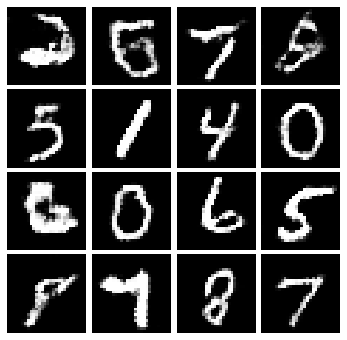

epoch=49, iteration=183801, WD=4.362274169921875, D_loss=-0.4914522171020508, G_loss=-27.5274600982666
epoch=49, iteration=183901, WD=13.556840896606445, D_loss=-10.154406547546387, G_loss=-29.204832077026367
epoch=49, iteration=184001, WD=6.224311828613281, D_loss=-2.616833209991455, G_loss=-45.70247268676758
epoch=49, iteration=184101, WD=10.659893035888672, D_loss=-7.142870903015137, G_loss=14.319064140319824
epoch=49, iteration=184201, WD=5.200128555297852, D_loss=-0.5180964469909668, G_loss=-5.731027603149414
epoch=49, iteration=184301, WD=19.20043182373047, D_loss=-14.905245780944824, G_loss=41.78388595581055
epoch=49, iteration=184401, WD=7.282615661621094, D_loss=-3.3167479038238525, G_loss=-108.59502410888672
epoch=49, iteration=184501, WD=13.051994323730469, D_loss=-8.795104026794434, G_loss=-48.48023223876953
epoch=49, iteration=184601, WD=4.6785993576049805, D_loss=-0.9610626697540283, G_loss=-11.49756145477295
epoch=49, iteration=184701, WD=0.4820709228515625, D_loss=3.366

In [12]:
g_ = Generator().cuda()
d_ = Discriminator().cuda()
loss2 = train(g_,d_,l=1e-4,n_epochs=50, weight_decay=False, classification=False)

Text(0.5,1,'Without Classification-WD')

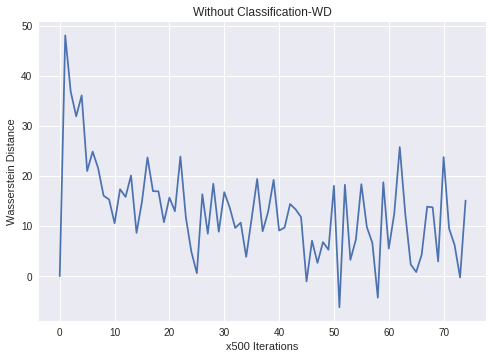

In [19]:
loss2 = np.array(loss2)
plt.plot(loss2[::500,0])
plt.xlabel("x500 Iterations")
plt.ylabel("Wasserstein Distance")
plt.title("Without Classification-WD")

Text(0.5,1,'Without Classification-D_Loss')

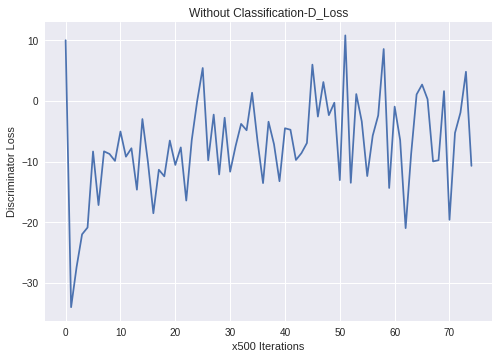

In [20]:
plt.plot(loss2[::500,1])
plt.xlabel("x500 Iterations")
plt.ylabel("Discriminator Loss")
plt.title("Without Classification-D_Loss")

Text(0.5,1,'Without Classification-G_Loss')

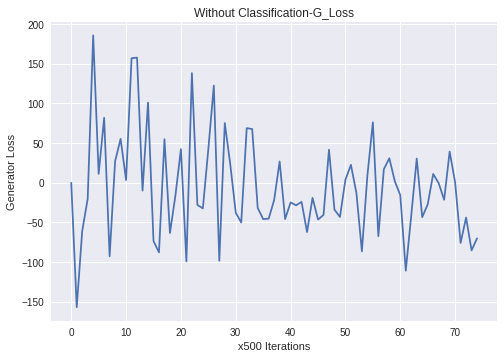

In [21]:
plt.plot(loss2[::500,2])
plt.xlabel("x500 Iterations")
plt.ylabel("Generator Loss")
plt.title("Without Classification-G_Loss")

In [0]:
ce = nn.CrossEntropyLoss(size_average=False)

learning rate : 0.0001 


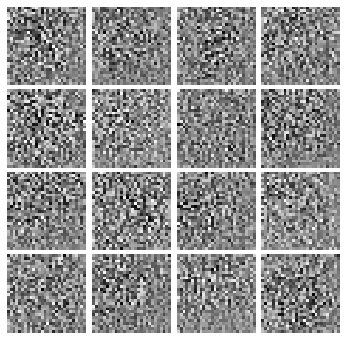

Labels :  (tensor(1.00000e-02 *
       [ 7.0497,  6.8855,  6.7588,  6.9007,  7.0030,  6.7269,  6.9184,
         6.7847,  6.8957,  7.0068,  6.9042,  6.8439,  6.8335,  6.9642,
         6.9788,  6.8711], device='cuda:0'), tensor([ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6], device='cuda:0'))
Classification Accuracy : 9 % 
epoch=0, iteration=1, WD=-0.00028502941131591797, D_loss=46.80938720703125, bce=36.81144332885742, G_loss=-0.03288865089416504


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch=0, iteration=101, WD=8.05594253540039, D_loss=33.185733795166016, bce=31.916152954101562, G_loss=13.064108848571777
epoch=0, iteration=201, WD=840.2301025390625, D_loss=-582.7157592773438, bce=52.82704544067383, G_loss=1465.910888671875
epoch=0, iteration=301, WD=1414.03173828125, D_loss=-838.4581909179688, bce=46.25458526611328, G_loss=1606.5609130859375
epoch=0, iteration=401, WD=1105.111083984375, D_loss=-626.5231323242188, bce=37.60486602783203, G_loss=1320.2510986328125
epoch=0, iteration=501, WD=1104.4505615234375, D_loss=-660.1309204101562, bce=16.712068557739258, G_loss=1181.732421875
epoch=0, iteration=601, WD=1091.9366455078125, D_loss=-611.18505859375, bce=21.843992233276367, G_loss=1168.132568359375
epoch=0, iteration=701, WD=1200.011474609375, D_loss=-646.5254516601562, bce=23.788719177246094, G_loss=1240.2176513671875
epoch=0, iteration=801, WD=857.9464111328125, D_loss=-420.40667724609375, bce=17.401552200317383, G_loss=1001.3193359375
epoch=0, iteration=901, WD=37

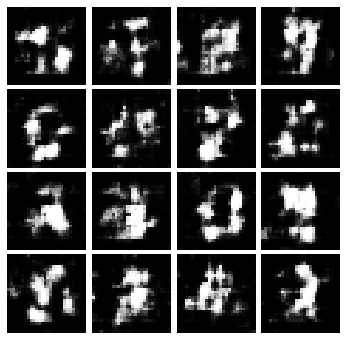

Labels :  (tensor([ 4.6048,  1.6846,  5.3644,  7.3013,  9.8675,  4.3292,  6.3919,
         9.6823,  6.3258,  7.0154,  4.5046,  7.7753,  5.7508,  5.2934,
         3.5118,  7.3222], device='cuda:0'), tensor([ 5,  3,  3,  7,  6,  7,  8,  0,  2,  6,  0,  3,  8,  3,
         8,  3], device='cuda:0'))
Classification Accuracy : 81 % 
epoch=1, iteration=3801, WD=20.343841552734375, D_loss=-8.334285736083984, bce=6.839077472686768, G_loss=-101.31719207763672
epoch=1, iteration=3901, WD=25.9493408203125, D_loss=-6.501019477844238, bce=13.731009483337402, G_loss=-68.69535064697266
epoch=1, iteration=4001, WD=23.233257293701172, D_loss=-7.0475263595581055, bce=9.988595008850098, G_loss=-28.601465225219727
epoch=1, iteration=4101, WD=15.834251403808594, D_loss=2.3206443786621094, bce=9.852205276489258, G_loss=-21.843881607055664
epoch=1, iteration=4201, WD=38.181602478027344, D_loss=-18.03545570373535, bce=13.294889450073242, G_loss=-61.76620864868164
epoch=1, iteration=4301, WD=24.533538818359375,

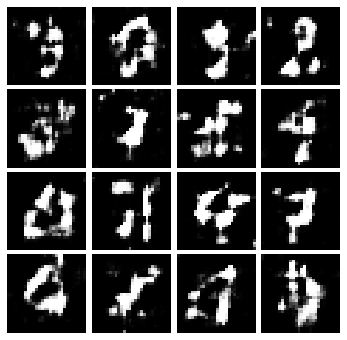

Labels :  (tensor([  9.0491,   9.7325,   5.0032,  10.1242,   6.3669,   4.9077,
          7.2041,   5.7263,  12.1400,  12.6989,  10.5985,   6.7450,
          5.8245,   4.9031,   8.4797,   8.4350], device='cuda:0'), tensor([ 7,  0,  5,  3,  2,  1,  5,  4,  0,  2,  9,  7,  9,  8,
         3,  3], device='cuda:0'))
Classification Accuracy : 87 % 
epoch=2, iteration=7501, WD=29.203224182128906, D_loss=-14.653624534606934, bce=4.210736274719238, G_loss=-63.04574203491211
epoch=2, iteration=7601, WD=19.581886291503906, D_loss=-3.412141799926758, bce=6.282186508178711, G_loss=-74.45030212402344
epoch=2, iteration=7701, WD=27.62744903564453, D_loss=-13.284994125366211, bce=3.5307440757751465, G_loss=-81.89859008789062
epoch=2, iteration=7801, WD=36.967803955078125, D_loss=-21.18365478515625, bce=6.111847877502441, G_loss=-59.61900329589844
epoch=2, iteration=7901, WD=24.68316650390625, D_loss=-11.483880996704102, bce=2.372478723526001, G_loss=-76.94168853759766
epoch=2, iteration=8001, WD=34.02

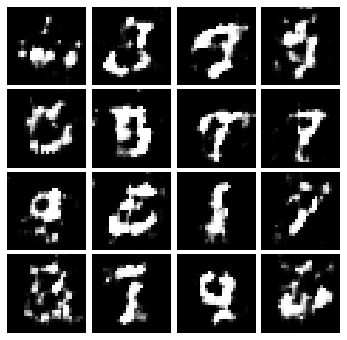

Labels :  (tensor([ 11.9308,  16.3829,   8.7205,   4.9755,   9.4458,   4.3591,
          6.9765,   7.6237,   9.3551,  13.1532,   3.9186,   3.5850,
          9.4230,   7.3734,   6.3878,  18.3803], device='cuda:0'), tensor([ 2,  3,  5,  9,  0,  3,  9,  7,  9,  0,  1,  8,  3,  3,
         9,  6], device='cuda:0'))
Classification Accuracy : 89 % 
epoch=3, iteration=11301, WD=40.48278045654297, D_loss=-21.951377868652344, bce=3.1374096870422363, G_loss=-80.5805892944336
epoch=3, iteration=11401, WD=41.338783264160156, D_loss=-22.581188201904297, bce=6.101208686828613, G_loss=-107.79574584960938
epoch=3, iteration=11501, WD=37.995670318603516, D_loss=-15.202495574951172, bce=6.398809909820557, G_loss=-40.90489959716797
epoch=3, iteration=11601, WD=54.292789459228516, D_loss=-33.69343948364258, bce=4.2514328956604, G_loss=66.67382049560547
epoch=3, iteration=11701, WD=38.36772155761719, D_loss=-20.97469139099121, bce=1.1010456085205078, G_loss=-21.36040496826172
epoch=3, iteration=11801, WD=6

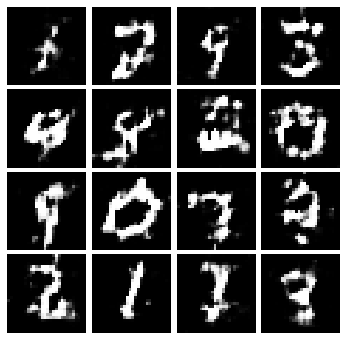

Labels :  (tensor([  3.3282,  10.6433,   5.6648,   9.6238,  13.0533,   4.9103,
         11.5276,   6.1947,   6.2953,  16.3208,  12.1598,   6.0631,
          9.9129,   5.8902,   4.8734,   4.7750], device='cuda:0'), tensor([ 1,  7,  4,  3,  4,  8,  2,  0,  9,  0,  7,  9,  2,  1,
         3,  3], device='cuda:0'))
Classification Accuracy : 93 % 
epoch=4, iteration=15001, WD=99.5513687133789, D_loss=-82.6245346069336, bce=0.5907077789306641, G_loss=-96.94820404052734
epoch=4, iteration=15101, WD=44.50828552246094, D_loss=-27.40531349182129, bce=1.5067315101623535, G_loss=-43.38650894165039
epoch=4, iteration=15201, WD=38.616119384765625, D_loss=-18.638561248779297, bce=0.9067144393920898, G_loss=-13.335617065429688
epoch=4, iteration=15301, WD=30.558879852294922, D_loss=-11.375920295715332, bce=3.387005090713501, G_loss=5.661708354949951
epoch=4, iteration=15401, WD=37.05712127685547, D_loss=-21.00519561767578, bce=0.7925333976745605, G_loss=-89.58722686767578
epoch=4, iteration=15501, WD=

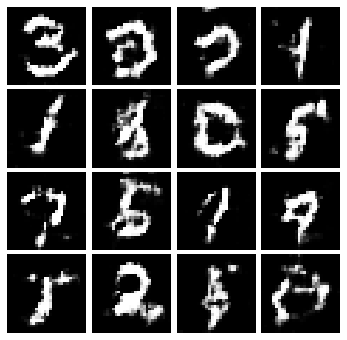

Labels :  (tensor([ 13.0625,   8.2816,   8.4966,   5.4357,   7.7616,   7.0485,
         13.8359,   6.6863,  13.8345,   7.2472,   3.8930,   6.8989,
          5.5500,  19.3744,   4.8399,   5.1860], device='cuda:0'), tensor([ 3,  0,  7,  1,  1,  8,  0,  8,  7,  5,  7,  7,  1,  2,
         8,  0], device='cuda:0'))
Classification Accuracy : 94 % 
epoch=5, iteration=18801, WD=48.539466857910156, D_loss=-32.08377456665039, bce=2.6263017654418945, G_loss=-63.66244888305664
epoch=5, iteration=18901, WD=37.92399978637695, D_loss=-21.521282196044922, bce=1.4511539936065674, G_loss=-31.337833404541016
epoch=5, iteration=19001, WD=38.67642593383789, D_loss=-21.019906997680664, bce=0.432924747467041, G_loss=-21.486377716064453
epoch=5, iteration=19101, WD=38.58367919921875, D_loss=-19.68195343017578, bce=2.1599955558776855, G_loss=36.50049591064453
epoch=5, iteration=19201, WD=43.16049575805664, D_loss=-22.507530212402344, bce=8.114476203918457, G_loss=-28.336742401123047
epoch=5, iteration=19301, 

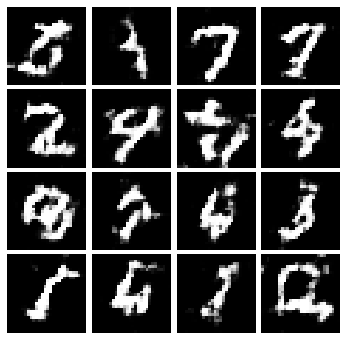

Labels :  (tensor([  7.6510,   3.9748,  14.2526,   8.9121,  17.9602,   6.7613,
          6.6919,   4.0655,   6.3145,   4.3114,   8.6942,   4.7064,
          5.0350,   8.7781,   4.6151,  13.4659], device='cuda:0'), tensor([ 3,  3,  7,  7,  2,  4,  8,  4,  8,  7,  6,  3,  1,  6,
         2,  2], device='cuda:0'))
Classification Accuracy : 95 % 
epoch=6, iteration=22501, WD=43.29515075683594, D_loss=-23.92316246032715, bce=4.821752548217773, G_loss=17.08826446533203
epoch=6, iteration=22601, WD=30.596145629882812, D_loss=-12.687080383300781, bce=1.483048915863037, G_loss=-101.4749984741211
epoch=6, iteration=22701, WD=43.74065399169922, D_loss=-28.848297119140625, bce=2.17008113861084, G_loss=-51.123809814453125
epoch=6, iteration=22801, WD=39.035911560058594, D_loss=-23.857450485229492, bce=1.702110767364502, G_loss=46.791500091552734
epoch=6, iteration=22901, WD=53.09373474121094, D_loss=-37.28562927246094, bce=0.832017183303833, G_loss=-117.1239013671875
epoch=6, iteration=23001, WD=37

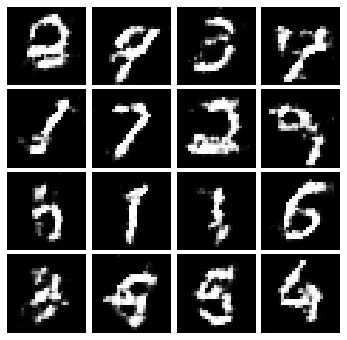

Labels :  (tensor([  6.7391,   9.0381,   9.2364,   7.2338,   7.2220,   8.5122,
         16.9475,   5.2708,   2.3643,   5.7322,   7.1379,  10.8139,
          2.7794,   5.4866,   7.6968,   5.9121], device='cuda:0'), tensor([ 2,  9,  3,  7,  1,  7,  2,  3,  8,  1,  1,  5,  3,  5,
         5,  4], device='cuda:0'))
Classification Accuracy : 95 % 
epoch=7, iteration=26301, WD=29.45140838623047, D_loss=-15.548247337341309, bce=1.0033788681030273, G_loss=-58.02189254760742
epoch=7, iteration=26401, WD=55.181549072265625, D_loss=-41.59073257446289, bce=0.5712771415710449, G_loss=-59.95864486694336
epoch=7, iteration=26501, WD=30.292091369628906, D_loss=-17.739599227905273, bce=0.49725770950317383, G_loss=-72.2236328125
epoch=7, iteration=26601, WD=42.695899963378906, D_loss=-25.598491668701172, bce=0.5833609104156494, G_loss=42.229164123535156
epoch=7, iteration=26701, WD=28.075288772583008, D_loss=-13.765459060668945, bce=1.7845056056976318, G_loss=-21.042295455932617
epoch=7, iteration=26801

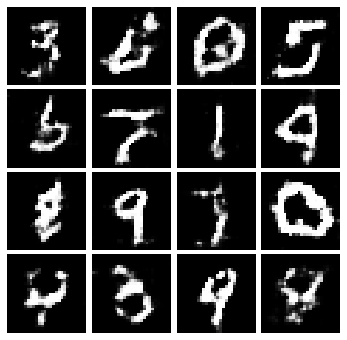

Labels :  (tensor([  8.4550,   7.8279,   7.1230,  15.9144,   4.4889,  15.6067,
          8.1101,   6.0270,   4.8638,   7.9280,   4.7446,   9.4775,
         10.0751,   7.9734,   7.3258,   7.7772], device='cuda:0'), tensor([ 3,  6,  0,  5,  6,  7,  1,  9,  8,  9,  3,  0,  4,  3,
         4,  4], device='cuda:0'))
Classification Accuracy : 96 % 
epoch=8, iteration=30001, WD=19.742095947265625, D_loss=-5.968970775604248, bce=0.6353039741516113, G_loss=-72.61380004882812
epoch=8, iteration=30101, WD=16.709924697875977, D_loss=-1.1918597221374512, bce=2.2784476280212402, G_loss=16.078256607055664
epoch=8, iteration=30201, WD=30.80959701538086, D_loss=-16.845762252807617, bce=0.8332505226135254, G_loss=1.4449787139892578
epoch=8, iteration=30301, WD=35.916053771972656, D_loss=-22.755327224731445, bce=0.8815023899078369, G_loss=10.772743225097656
epoch=8, iteration=30401, WD=45.23949432373047, D_loss=-28.355411529541016, bce=1.870044231414795, G_loss=-74.320068359375
epoch=8, iteration=30501, 

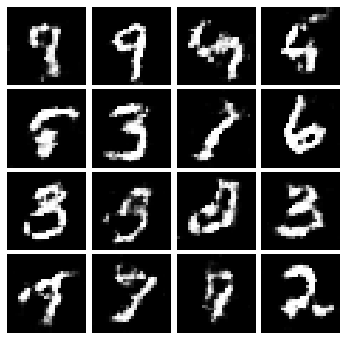

Labels :  (tensor([  4.7819,   9.3826,   2.4991,   4.4757,  12.0164,  16.4273,
          4.7113,  11.9640,   8.4548,   5.3403,   5.9794,  11.1308,
          7.9802,   7.5978,   3.1942,  18.2545], device='cuda:0'), tensor([ 7,  9,  4,  4,  5,  3,  1,  6,  3,  5,  2,  3,  7,  7,
         7,  2], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=9, iteration=33801, WD=19.824161529541016, D_loss=-10.135767936706543, bce=0.3116722106933594, G_loss=4.1315155029296875
epoch=9, iteration=33901, WD=28.578575134277344, D_loss=-12.470263481140137, bce=2.9098289012908936, G_loss=-93.92442321777344
epoch=9, iteration=34001, WD=29.837844848632812, D_loss=-12.983040809631348, bce=1.8018512725830078, G_loss=-121.02589416503906
epoch=9, iteration=34101, WD=27.58951759338379, D_loss=-16.913522720336914, bce=0.11943578720092773, G_loss=-10.540470123291016
epoch=9, iteration=34201, WD=39.29695129394531, D_loss=-26.200698852539062, bce=1.4061691761016846, G_loss=-88.71492767333984
epoch=9, iteration=

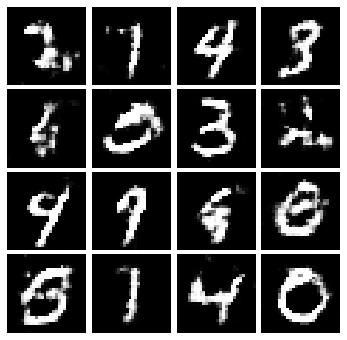

Labels :  (tensor([  9.4891,   4.9170,  13.4894,   9.2050,   2.6189,   5.2410,
         14.5473,   9.6622,   9.9397,   5.5308,   3.3271,   4.8600,
          5.3126,   5.6643,  12.6976,  10.1068], device='cuda:0'), tensor([ 2,  1,  4,  3,  4,  5,  3,  2,  4,  9,  6,  6,  5,  1,
         4,  0], device='cuda:0'))
Classification Accuracy : 96 % 
epoch=10, iteration=37501, WD=14.035301208496094, D_loss=-2.2356514930725098, bce=2.0671610832214355, G_loss=-119.52369689941406
epoch=10, iteration=37601, WD=13.959878921508789, D_loss=-3.6002118587493896, bce=0.38943982124328613, G_loss=-1.1535942554473877
epoch=10, iteration=37701, WD=32.020999908447266, D_loss=-18.666105270385742, bce=2.594910144805908, G_loss=-1.5033864974975586
epoch=10, iteration=37801, WD=35.14624786376953, D_loss=-25.116640090942383, bce=0.45559263229370117, G_loss=-107.66464233398438
epoch=10, iteration=37901, WD=18.078643798828125, D_loss=-5.635240077972412, bce=1.8065638542175293, G_loss=-116.759765625
epoch=10, iterat

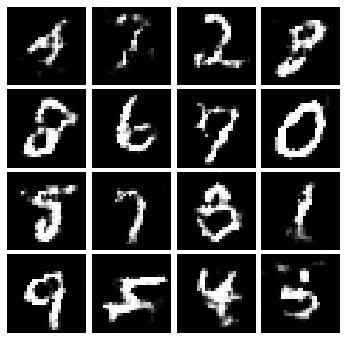

Labels :  (tensor([  4.5440,   2.7916,  13.5570,   3.8745,   6.9004,  11.4253,
          4.8074,  12.6968,   4.4265,   6.0266,   2.7889,   5.7093,
          8.8767,   9.6069,   9.9533,   2.6341], device='cuda:0'), tensor([ 4,  2,  2,  8,  8,  6,  7,  0,  8,  7,  3,  1,  9,  5,
         4,  3], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=11, iteration=41301, WD=42.286468505859375, D_loss=-31.021881103515625, bce=1.1387832164764404, G_loss=15.868659019470215
epoch=11, iteration=41401, WD=23.26465606689453, D_loss=-13.606056213378906, bce=0.3347010612487793, G_loss=-54.69070053100586
epoch=11, iteration=41501, WD=26.4189453125, D_loss=-16.11783790588379, bce=0.20969152450561523, G_loss=-60.52683639526367
epoch=11, iteration=41601, WD=10.438034057617188, D_loss=4.400854110717773, bce=2.3802669048309326, G_loss=9.142378807067871
epoch=11, iteration=41701, WD=18.05565643310547, D_loss=-6.348981857299805, bce=0.4535408020019531, G_loss=-135.1058807373047
epoch=11, iteration=41801,

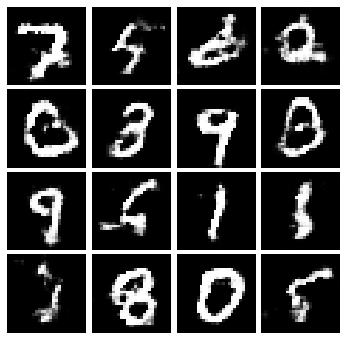

Labels :  (tensor([ 16.1157,   3.7748,   4.5456,   5.2639,   5.4928,   8.6782,
         11.9229,   5.8780,  10.4255,   7.8581,   7.6322,   5.8118,
          1.5887,   8.0380,  15.8292,   9.1600], device='cuda:0'), tensor([ 7,  5,  2,  2,  0,  3,  9,  3,  9,  5,  1,  1,  2,  8,
         0,  5], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=12, iteration=45001, WD=21.857860565185547, D_loss=-9.372720718383789, bce=0.3898322582244873, G_loss=-61.715797424316406
epoch=12, iteration=45101, WD=33.192081451416016, D_loss=-22.814285278320312, bce=0.29072093963623047, G_loss=-36.82478713989258
epoch=12, iteration=45201, WD=16.163158416748047, D_loss=-6.9627685546875, bce=0.1103982925415039, G_loss=-45.470420837402344
epoch=12, iteration=45301, WD=10.519317626953125, D_loss=0.5351076126098633, bce=0.38295650482177734, G_loss=-78.77647399902344
epoch=12, iteration=45401, WD=12.248054504394531, D_loss=-1.8642487525939941, bce=0.5559868812561035, G_loss=-100.87409973144531
epoch=12, itera

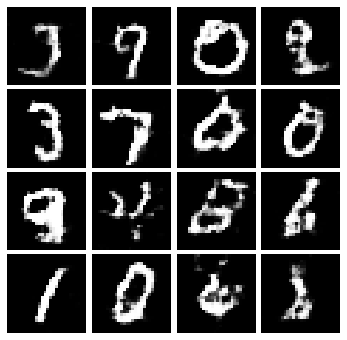

Labels :  (tensor([  6.2806,   6.0013,  11.9026,   5.0271,  10.2130,  17.5455,
          9.2398,  10.0379,   7.8457,   7.8112,   4.1283,   7.8450,
         10.5324,   9.8270,   9.6359,   4.2197], device='cuda:0'), tensor([ 7,  9,  0,  1,  3,  7,  0,  0,  3,  4,  6,  6,  1,  0,
         6,  1], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=13, iteration=48801, WD=25.623138427734375, D_loss=-13.511192321777344, bce=1.4651837348937988, G_loss=-79.91828918457031
epoch=13, iteration=48901, WD=4.562729835510254, D_loss=8.026262283325195, bce=3.161834478378296, G_loss=-2.570892095565796
epoch=13, iteration=49001, WD=14.8358154296875, D_loss=-4.529216289520264, bce=1.3235154151916504, G_loss=-106.94745635986328
epoch=13, iteration=49101, WD=18.74407196044922, D_loss=-10.52821159362793, bce=0.23606300354003906, G_loss=-95.05770111083984
epoch=13, iteration=49201, WD=48.17765808105469, D_loss=-36.91183853149414, bce=0.08607864379882812, G_loss=-32.15024948120117
epoch=13, iteration=493

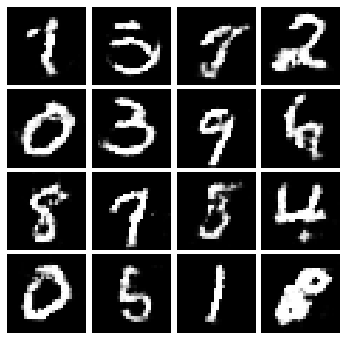

Labels :  (tensor([  5.9743,  10.9033,   2.7507,  17.8670,  13.8515,  15.8744,
         10.3398,   6.9097,   9.0235,  10.0294,   5.3638,  17.4033,
         12.3500,   3.2789,   8.6347,  11.6693], device='cuda:0'), tensor([ 1,  3,  7,  2,  0,  3,  9,  6,  8,  7,  5,  4,  0,  6,
         1,  8], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=14, iteration=52501, WD=26.872726440429688, D_loss=-17.121971130371094, bce=0.1103062629699707, G_loss=-85.52253723144531
epoch=14, iteration=52601, WD=24.706491470336914, D_loss=-15.748146057128906, bce=0.1410069465637207, G_loss=-17.066532135009766
epoch=14, iteration=52701, WD=51.84516143798828, D_loss=-39.91831970214844, bce=3.149420738220215, G_loss=-97.16158294677734
epoch=14, iteration=52801, WD=21.703773498535156, D_loss=-11.726035118103027, bce=0.09772109985351562, G_loss=-103.67489624023438
epoch=14, iteration=52901, WD=29.59084701538086, D_loss=-17.168201446533203, bce=3.213041305541992, G_loss=-32.54732894897461
epoch=14, iterati

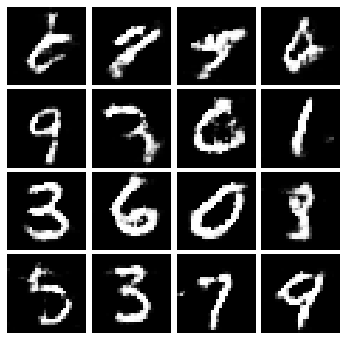

Labels :  (tensor([  4.0726,   5.2889,   2.9445,   5.3932,   9.5294,   9.1312,
          4.7015,   9.2897,  16.8432,  18.1763,  10.4542,   3.2876,
          9.2237,  14.3463,  10.1751,   8.2882], device='cuda:0'), tensor([ 8,  8,  4,  6,  9,  3,  6,  1,  3,  6,  0,  8,  5,  3,
         7,  9], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=15, iteration=56301, WD=31.08502197265625, D_loss=-23.622631072998047, bce=0.031249046325683594, G_loss=-48.92417907714844
epoch=15, iteration=56401, WD=20.536426544189453, D_loss=-12.011090278625488, bce=0.5186090469360352, G_loss=-30.4825382232666
epoch=15, iteration=56501, WD=18.52820587158203, D_loss=-9.159785270690918, bce=0.1820392608642578, G_loss=-29.497833251953125
epoch=15, iteration=56601, WD=28.748252868652344, D_loss=-15.254617691040039, bce=2.8601365089416504, G_loss=7.62822961807251
epoch=15, iteration=56701, WD=25.56298065185547, D_loss=-16.492874145507812, bce=1.188943862915039, G_loss=-64.99293518066406
epoch=15, iteration=

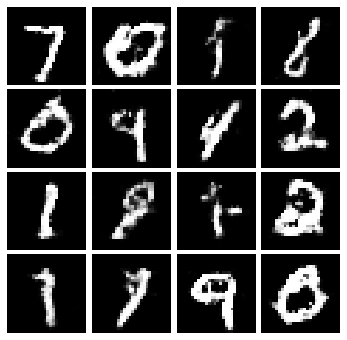

Labels :  (tensor([ 15.1330,  10.7692,   2.1045,   4.8129,   7.9267,   5.4680,
          6.1086,  10.5038,   8.1848,   4.8353,   0.9593,  11.8117,
          4.6483,   4.0388,  13.1960,  10.3493], device='cuda:0'), tensor([ 7,  0,  1,  8,  0,  9,  4,  2,  1,  8,  8,  2,  1,  7,
         9,  0], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=16, iteration=60001, WD=21.98839569091797, D_loss=-15.315911293029785, bce=0.18292713165283203, G_loss=-12.181417465209961
epoch=16, iteration=60101, WD=18.10057830810547, D_loss=-6.547879695892334, bce=0.7070193290710449, G_loss=-29.184669494628906
epoch=16, iteration=60201, WD=18.95006561279297, D_loss=-8.309176445007324, bce=1.739837646484375, G_loss=-72.27276611328125
epoch=16, iteration=60301, WD=30.809555053710938, D_loss=-15.740245819091797, bce=7.311365127563477, G_loss=-123.42902374267578
epoch=16, iteration=60401, WD=33.87792205810547, D_loss=-24.08955192565918, bce=2.159292459487915, G_loss=-93.91800689697266
epoch=16, iteration=6

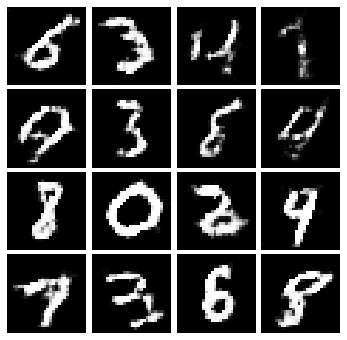

Labels :  (tensor([  6.6619,  11.1796,   8.2503,   1.1164,   5.8899,   9.1003,
          5.3020,   5.5959,   5.3021,  17.4679,  13.1622,   8.5634,
         12.9253,   9.7448,   7.4704,   6.8429], device='cuda:0'), tensor([ 6,  3,  4,  8,  9,  3,  8,  4,  8,  0,  2,  4,  7,  3,
         6,  8], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=17, iteration=63801, WD=19.803077697753906, D_loss=-9.405550003051758, bce=3.0238003730773926, G_loss=-70.44908142089844
epoch=17, iteration=63901, WD=23.294475555419922, D_loss=-13.097034454345703, bce=2.44034743309021, G_loss=-33.10063171386719
epoch=17, iteration=64001, WD=21.708127975463867, D_loss=-15.070474624633789, bce=0.06650781631469727, G_loss=-17.53207015991211
epoch=17, iteration=64101, WD=25.16278839111328, D_loss=-16.41908073425293, bce=0.1858386993408203, G_loss=-105.48894500732422
epoch=17, iteration=64201, WD=32.677574157714844, D_loss=-23.702239990234375, bce=0.8511228561401367, G_loss=-111.62088012695312
epoch=17, iterati

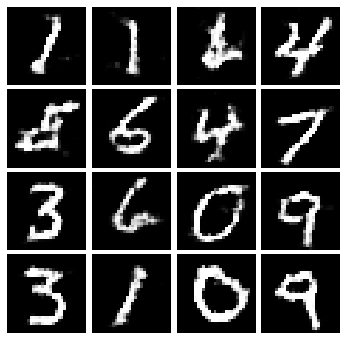

Labels :  (tensor([  5.9565,   5.1856,   3.2954,  14.4441,   8.8856,   9.0523,
          9.8217,  12.7947,  12.2639,  10.5463,   5.7032,  10.8840,
         13.7454,   4.4853,  16.3011,  12.3921], device='cuda:0'), tensor([ 1,  1,  6,  4,  5,  6,  4,  7,  3,  6,  0,  9,  3,  1,
         0,  9], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=18, iteration=67501, WD=2.0759401321411133, D_loss=7.038084983825684, bce=0.05393028259277344, G_loss=-13.347900390625
epoch=18, iteration=67601, WD=15.200506210327148, D_loss=-6.307053565979004, bce=0.41228652000427246, G_loss=-34.67690658569336
epoch=18, iteration=67701, WD=16.717567443847656, D_loss=-7.202195644378662, bce=1.490797519683838, G_loss=-23.353670120239258
epoch=18, iteration=67801, WD=5.5570526123046875, D_loss=3.7960448265075684, bce=2.301510810852051, G_loss=-59.656219482421875
epoch=18, iteration=67901, WD=18.564437866210938, D_loss=-8.945796012878418, bce=2.168499708175659, G_loss=-109.60670471191406
epoch=18, iteration=6

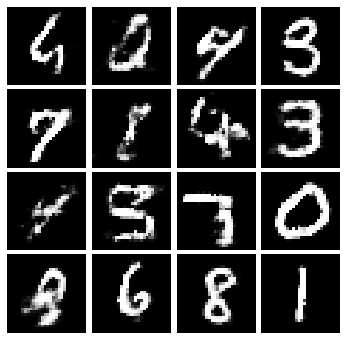

Labels :  (tensor([  3.7299,   1.9156,   9.1991,   8.4350,  11.6645,   3.7039,
          3.4931,  12.8267,   1.0788,  10.7055,  18.0424,  14.8624,
          6.1251,  11.0327,  12.0639,   7.1166], device='cuda:0'), tensor([ 6,  2,  4,  3,  7,  8,  6,  3,  4,  3,  7,  0,  8,  6,
         8,  1], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=19, iteration=71301, WD=9.274837493896484, D_loss=-1.600090742111206, bce=0.61763596534729, G_loss=-33.614105224609375
epoch=19, iteration=71401, WD=24.737060546875, D_loss=-16.843624114990234, bce=0.19865131378173828, G_loss=-4.677886962890625
epoch=19, iteration=71501, WD=29.470256805419922, D_loss=-22.61065673828125, bce=0.05218839645385742, G_loss=-67.94548797607422
epoch=19, iteration=71601, WD=12.537521362304688, D_loss=-4.875533580780029, bce=0.09849929809570312, G_loss=-54.70664978027344
epoch=19, iteration=71701, WD=5.812751770019531, D_loss=1.5696830749511719, bce=0.9531197547912598, G_loss=-81.21238708496094
epoch=19, iteration=71

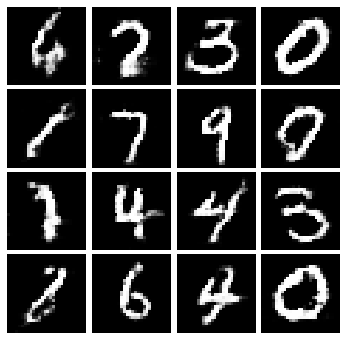

Labels :  (tensor([  7.6098,   9.6378,  14.1685,  16.1308,   4.9380,  12.9192,
          8.5254,   4.7557,   6.5352,  10.1571,  12.4128,  11.4315,
          3.2362,   9.4277,  11.5335,  12.7904], device='cuda:0'), tensor([ 6,  2,  3,  0,  1,  7,  9,  0,  1,  4,  4,  3,  8,  6,
         4,  0], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=20, iteration=75001, WD=32.30078887939453, D_loss=-24.710657119750977, bce=0.06693458557128906, G_loss=-114.03839111328125
epoch=20, iteration=75101, WD=34.89479064941406, D_loss=-28.33739471435547, bce=0.011650562286376953, G_loss=-117.07117462158203
epoch=20, iteration=75201, WD=29.313568115234375, D_loss=-20.65165138244629, bce=0.025915145874023438, G_loss=-169.01943969726562
epoch=20, iteration=75301, WD=34.226104736328125, D_loss=-19.76685905456543, bce=6.436044692993164, G_loss=-156.3692626953125
epoch=20, iteration=75401, WD=27.342041015625, D_loss=-19.836143493652344, bce=0.8890426158905029, G_loss=-133.52108764648438
epoch=20, itera

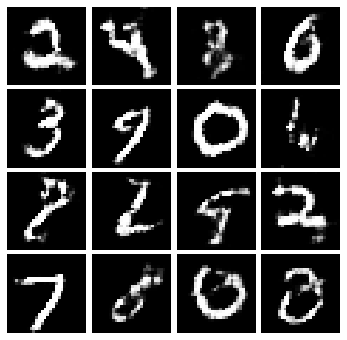

Labels :  (tensor([  8.7256,   3.5030,   2.8427,   8.3133,   9.1733,   5.0133,
         19.1865,   2.6087,   7.6450,  10.6623,   6.6775,   6.2227,
         15.4519,   1.9781,  14.2777,   3.9270], device='cuda:0'), tensor([ 2,  4,  8,  0,  3,  7,  0,  4,  8,  2,  5,  2,  7,  8,
         0,  0], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=21, iteration=78801, WD=23.59418487548828, D_loss=-17.57620620727539, bce=0.23513507843017578, G_loss=-106.66266632080078
epoch=21, iteration=78901, WD=13.008308410644531, D_loss=-5.655677318572998, bce=0.13319015502929688, G_loss=-104.33100891113281
epoch=21, iteration=79001, WD=30.58141326904297, D_loss=-22.6788387298584, bce=0.8970656394958496, G_loss=-110.79951477050781
epoch=21, iteration=79101, WD=34.24164581298828, D_loss=-21.87437629699707, bce=5.855405330657959, G_loss=-131.93443298339844
epoch=21, iteration=79201, WD=20.998077392578125, D_loss=-13.283979415893555, bce=0.26429033279418945, G_loss=-149.1082305908203
epoch=21, iterati

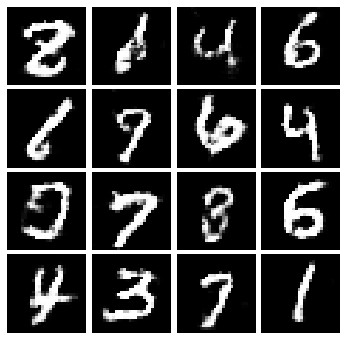

Labels :  (tensor([  9.6036,   4.1483,   7.8515,  11.5762,   7.9188,   5.7342,
         14.4764,   9.6018,   3.7641,  13.1126,   5.9231,   9.8956,
         12.6111,  12.6882,   8.9211,  11.1906], device='cuda:0'), tensor([ 8,  1,  4,  6,  1,  9,  6,  4,  0,  7,  8,  6,  4,  3,
         7,  1], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=22, iteration=82501, WD=40.36971664428711, D_loss=-33.37439727783203, bce=0.24767160415649414, G_loss=-56.03665542602539
epoch=22, iteration=82601, WD=7.8266143798828125, D_loss=0.16643714904785156, bce=0.2653069496154785, G_loss=-76.9042739868164
epoch=22, iteration=82701, WD=18.26276397705078, D_loss=-6.872254848480225, bce=4.613815784454346, G_loss=-29.741357803344727
epoch=22, iteration=82801, WD=-3.9168834686279297, D_loss=20.411455154418945, bce=8.935497283935547, G_loss=-13.203837394714355
epoch=22, iteration=82901, WD=14.375236511230469, D_loss=-4.605512619018555, bce=2.1864795684814453, G_loss=-29.121217727661133
epoch=22, iteration

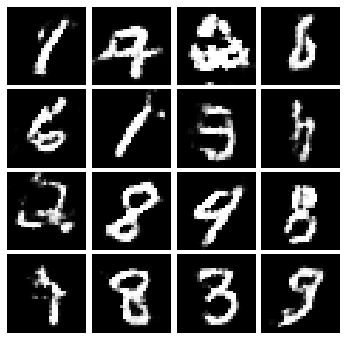

Labels :  (tensor([  6.8310,   2.6151,   8.5259,   4.9102,   6.0345,   9.1537,
          8.2250,   2.5919,   8.1737,  11.1155,   8.4899,   6.1004,
          2.6164,  10.4380,  12.0819,   5.2145], device='cuda:0'), tensor([ 1,  7,  2,  6,  6,  1,  3,  9,  2,  8,  9,  8,  9,  8,
         3,  3], device='cuda:0'))
Classification Accuracy : 97 % 
epoch=23, iteration=86301, WD=14.938064575195312, D_loss=-8.4384183883667, bce=0.10829544067382812, G_loss=-102.4993667602539
epoch=23, iteration=86401, WD=30.86646270751953, D_loss=-21.660837173461914, bce=0.05479168891906738, G_loss=-83.38224792480469
epoch=23, iteration=86501, WD=8.550727844238281, D_loss=-1.188622236251831, bce=1.493976354598999, G_loss=-121.39452362060547
epoch=23, iteration=86601, WD=21.830062866210938, D_loss=-12.17652702331543, bce=1.4763293266296387, G_loss=-109.19983673095703
epoch=23, iteration=86701, WD=7.071510314941406, D_loss=0.3121539354324341, bce=0.2158886194229126, G_loss=-50.83257293701172
epoch=23, iteration=8

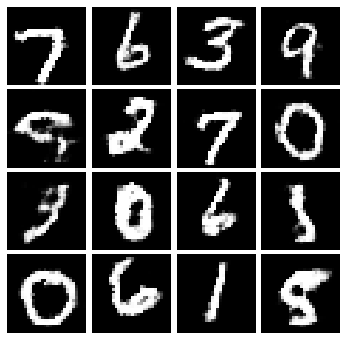

Labels :  (tensor([ 14.6637,  12.1042,  14.7419,   7.2126,   1.5949,   7.4803,
          9.4983,   8.3437,   3.1932,   9.0675,  11.9678,   9.5398,
         11.1402,  19.7693,   9.1789,   3.0553], device='cuda:0'), tensor([ 7,  6,  3,  9,  9,  2,  7,  0,  3,  0,  6,  1,  0,  6,
         1,  5], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=24, iteration=90001, WD=11.268689155578613, D_loss=-4.45529317855835, bce=0.07203245162963867, G_loss=42.69102478027344
epoch=24, iteration=90101, WD=3.99627685546875, D_loss=1.8587441444396973, bce=0.43272924423217773, G_loss=-55.7484245300293
epoch=24, iteration=90201, WD=22.459861755371094, D_loss=-14.504440307617188, bce=0.3748571276664734, G_loss=-101.8238754272461
epoch=24, iteration=90301, WD=14.508628845214844, D_loss=-8.093900680541992, bce=0.14615774154663086, G_loss=-88.61189270019531
epoch=24, iteration=90401, WD=15.757484436035156, D_loss=-8.761076927185059, bce=0.07306194305419922, G_loss=-87.49566650390625
epoch=24, iteration=

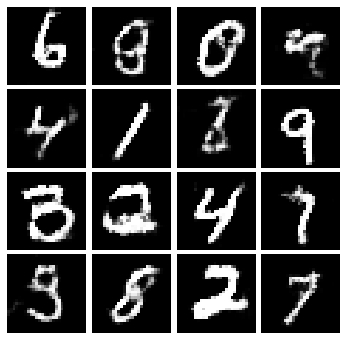

Labels :  (tensor([ 14.0752,   2.2939,   9.9286,   2.4090,   9.0397,   8.1345,
          1.9967,  11.7528,  10.1225,  12.4252,  11.8608,   6.3628,
          4.5349,   6.1207,  19.2686,   6.6938], device='cuda:0'), tensor([ 6,  8,  0,  9,  4,  1,  3,  9,  3,  2,  4,  7,  3,  8,
         2,  7], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=25, iteration=93801, WD=21.49627685546875, D_loss=-13.666292190551758, bce=0.5577297210693359, G_loss=-14.485040664672852
epoch=25, iteration=93901, WD=24.587562561035156, D_loss=-15.787126541137695, bce=0.032933712005615234, G_loss=-109.94818115234375
epoch=25, iteration=94001, WD=1.811370849609375, D_loss=5.170388221740723, bce=0.2473304271697998, G_loss=-79.38539123535156
epoch=25, iteration=94101, WD=12.881965637207031, D_loss=-6.8543267250061035, bce=0.008828163146972656, G_loss=-76.74832916259766
epoch=25, iteration=94201, WD=15.70327377319336, D_loss=-7.75616455078125, bce=0.37070584297180176, G_loss=-53.35284423828125
epoch=25, itera

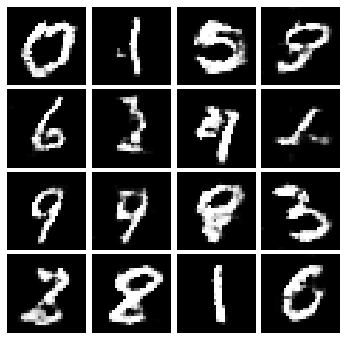

Labels :  (tensor([ 13.5107,   5.6992,   3.6186,   4.5928,  10.7768,   5.7674,
          0.8460,  -0.4514,   6.1337,   4.1047,  10.0668,   8.1009,
          4.6573,  14.7040,   8.5511,   2.6196], device='cuda:0'), tensor([ 0,  1,  5,  8,  6,  2,  9,  2,  9,  9,  8,  3,  3,  8,
         1,  6], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=26, iteration=97501, WD=19.716842651367188, D_loss=-13.06680965423584, bce=0.2848942279815674, G_loss=-101.77136993408203
epoch=26, iteration=97601, WD=20.73737335205078, D_loss=-12.553494453430176, bce=1.1236292123794556, G_loss=-116.45298767089844
epoch=26, iteration=97701, WD=33.97581481933594, D_loss=-25.232662200927734, bce=2.485178232192993, G_loss=-128.8824920654297
epoch=26, iteration=97801, WD=21.792789459228516, D_loss=-14.13936996459961, bce=1.058619737625122, G_loss=-67.22761535644531
epoch=26, iteration=97901, WD=5.5713653564453125, D_loss=0.9707174301147461, bce=0.07251167297363281, G_loss=-59.282196044921875
epoch=26, iteratio

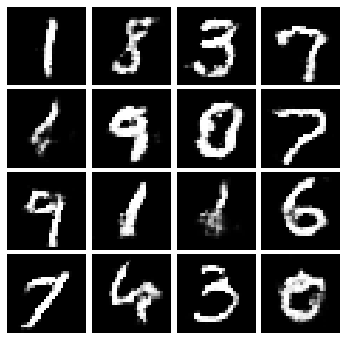

Labels :  (tensor([  7.2320,   2.8712,  12.3259,   8.4911,  -1.2128,   9.6269,
          7.1138,  13.1059,   8.9513,   7.1420,   0.7780,   8.3674,
          8.7605,   4.6877,  11.2527,   2.7582], device='cuda:0'), tensor([ 1,  8,  3,  7,  1,  9,  0,  7,  9,  1,  1,  6,  7,  4,
         3,  0], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=27, iteration=101301, WD=7.433832168579102, D_loss=-0.8981480598449707, bce=0.07617616653442383, G_loss=-14.422120094299316
epoch=27, iteration=101401, WD=6.434783935546875, D_loss=0.06356143951416016, bce=1.2268433570861816, G_loss=-56.65097427368164
epoch=27, iteration=101501, WD=22.72673797607422, D_loss=-16.112958908081055, bce=0.028430461883544922, G_loss=-69.78289794921875
epoch=27, iteration=101601, WD=-6.411754608154297, D_loss=12.480140686035156, bce=0.14339375495910645, G_loss=-59.3917350769043
epoch=27, iteration=101701, WD=15.83404541015625, D_loss=-9.662344932556152, bce=0.23173213005065918, G_loss=-48.096378326416016
epoch=27, 

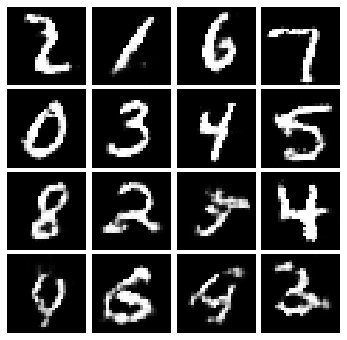

Labels :  (tensor([ 16.0084,   9.8971,  11.9876,  12.5049,  12.8443,  13.0172,
         11.9615,  13.8103,   8.3805,  11.5751,   1.2089,  14.5734,
          1.1966,   7.0616,   2.5717,   5.9755], device='cuda:0'), tensor([ 2,  1,  6,  7,  0,  3,  4,  5,  8,  2,  5,  4,  4,  5,
         4,  3], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=28, iteration=105001, WD=28.721908569335938, D_loss=-22.917142868041992, bce=0.06557309627532959, G_loss=-36.21751403808594
epoch=28, iteration=105101, WD=10.417213439941406, D_loss=-3.8786773681640625, bce=0.1099696159362793, G_loss=11.511103630065918
epoch=28, iteration=105201, WD=32.48377990722656, D_loss=-24.66611671447754, bce=0.2669816017150879, G_loss=37.36257553100586
epoch=28, iteration=105301, WD=15.752311706542969, D_loss=-7.830326080322266, bce=0.008907079696655273, G_loss=28.68366813659668
epoch=28, iteration=105401, WD=20.394180297851562, D_loss=-11.584549903869629, bce=0.307415246963501, G_loss=-16.367965698242188
epoch=28, it

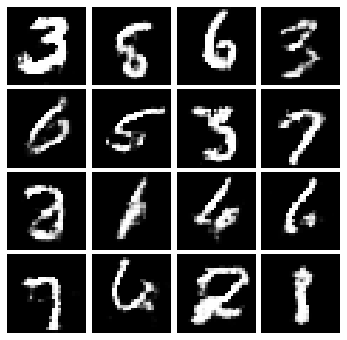

Labels :  (tensor([ 11.0676,  10.7889,  14.5124,   9.0943,   0.3024,  12.2083,
          8.5054,   7.3620,   8.0956,   4.2295,   3.6102,   4.8709,
         10.2461,   3.3620,  10.7368,   4.9528], device='cuda:0'), tensor([ 3,  5,  6,  3,  6,  5,  3,  7,  3,  1,  6,  6,  7,  6,
         2,  1], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=29, iteration=108801, WD=19.235347747802734, D_loss=-13.884310722351074, bce=0.02319622039794922, G_loss=-61.847713470458984
epoch=29, iteration=108901, WD=13.529529571533203, D_loss=-8.106531143188477, bce=0.008051872253417969, G_loss=-30.838624954223633
epoch=29, iteration=109001, WD=28.62944221496582, D_loss=-20.28227996826172, bce=2.874373197555542, G_loss=-27.50741195678711
epoch=29, iteration=109101, WD=3.6996307373046875, D_loss=1.5985355377197266, bce=0.0548405647277832, G_loss=-67.58304595947266
epoch=29, iteration=109201, WD=3.297454833984375, D_loss=2.6537671089172363, bce=0.24741306900978088, G_loss=-110.22565460205078
epoch=29, 

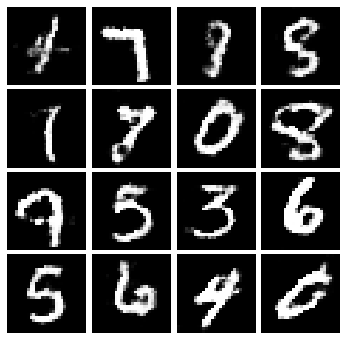

Labels :  (tensor([ -0.6138,  13.6714,   3.0605,   4.1732,   5.8700,   9.6538,
          7.8645,   6.8335,   7.7165,   7.7792,   9.6461,  16.8387,
          8.1762,  12.7921,   6.4572,   3.2441], device='cuda:0'), tensor([ 1,  7,  7,  8,  1,  7,  0,  8,  9,  5,  3,  6,  5,  6,
         4,  0], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=30, iteration=112501, WD=31.81494140625, D_loss=-25.11626625061035, bce=0.1349421739578247, G_loss=-102.24388122558594
epoch=30, iteration=112601, WD=7.748970031738281, D_loss=1.5761253833770752, bce=2.163370370864868, G_loss=-132.74696350097656
epoch=30, iteration=112701, WD=17.78106689453125, D_loss=-11.700505256652832, bce=0.1644921898841858, G_loss=-108.580810546875
epoch=30, iteration=112801, WD=2.567535400390625, D_loss=3.5078439712524414, bce=0.05819705128669739, G_loss=-96.01276397705078
epoch=30, iteration=112901, WD=17.316238403320312, D_loss=-12.249760627746582, bce=0.004604339599609375, G_loss=-35.79454040527344
epoch=30, iterati

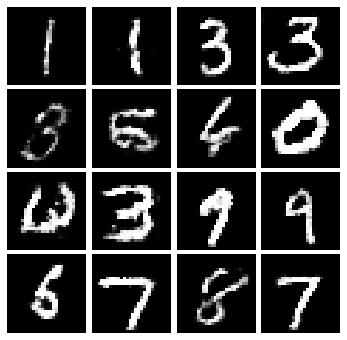

Labels :  (tensor([  4.0691,   5.8291,   9.7983,  10.8533,   3.0262,   1.3620,
          2.2554,   9.0727,   5.5434,  14.1060,   4.9728,   5.4048,
          5.8602,  15.0341,   5.7143,  12.2703], device='cuda:0'), tensor([ 1,  1,  3,  3,  3,  5,  6,  0,  4,  3,  9,  9,  6,  7,
         8,  7], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=31, iteration=116301, WD=13.627967834472656, D_loss=-8.38136100769043, bce=0.08811569213867188, G_loss=-63.44706726074219
epoch=31, iteration=116401, WD=12.027046203613281, D_loss=-6.690056800842285, bce=0.07436227798461914, G_loss=-120.27261352539062
epoch=31, iteration=116501, WD=-2.48565673828125, D_loss=7.932492733001709, bce=0.4246082305908203, G_loss=-61.59340286254883
epoch=31, iteration=116601, WD=17.979219436645508, D_loss=-12.293472290039062, bce=0.17004919052124023, G_loss=-31.2358455657959
epoch=31, iteration=116701, WD=18.77724266052246, D_loss=-13.224255561828613, bce=0.49048304557800293, G_loss=-1.6236917972564697
epoch=31, it

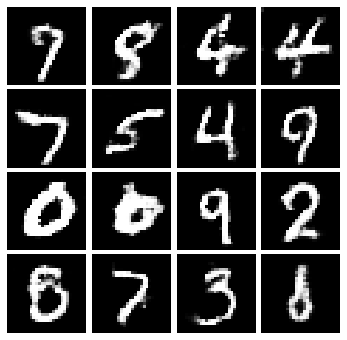

Labels :  (tensor([  7.0705,   0.4597,   4.7298,  11.9480,  11.8857,  11.1009,
          9.3574,   7.1061,  13.6036,   4.9067,   9.5507,   9.1203,
          0.8565,  10.9886,  10.2429,   0.8338], device='cuda:0'), tensor([ 7,  8,  4,  4,  7,  5,  4,  9,  0,  0,  9,  2,  0,  7,
         3,  8], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=32, iteration=120001, WD=6.779167175292969, D_loss=-1.4927608966827393, bce=0.2903030514717102, G_loss=-58.53218460083008
epoch=32, iteration=120101, WD=16.426925659179688, D_loss=-10.150102615356445, bce=0.2941265106201172, G_loss=-63.66683578491211
epoch=32, iteration=120201, WD=8.213478088378906, D_loss=-2.696089267730713, bce=0.17457151412963867, G_loss=-94.63345336914062
epoch=32, iteration=120301, WD=23.02520751953125, D_loss=-15.081918716430664, bce=2.2719173431396484, G_loss=-74.91287231445312
epoch=32, iteration=120401, WD=15.515331268310547, D_loss=-9.408039093017578, bce=0.2626621723175049, G_loss=-60.96501922607422
epoch=32, iter

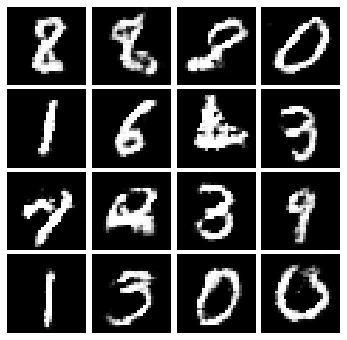

Labels :  (tensor([  6.8280,   5.3361,   7.4738,  11.8980,   8.2043,   9.7358,
          9.1155,   7.8724,   3.3874,   3.8226,   8.8911,   4.5582,
          6.9659,   9.0727,   9.9730,   8.2929], device='cuda:0'), tensor([ 8,  8,  8,  0,  1,  6,  6,  3,  7,  4,  3,  9,  1,  3,
         0,  0], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=33, iteration=123801, WD=3.35284423828125, D_loss=1.2114801406860352, bce=0.0875558853149414, G_loss=-25.756698608398438
epoch=33, iteration=123901, WD=16.709896087646484, D_loss=-10.812108993530273, bce=0.34891852736473083, G_loss=31.792137145996094
epoch=33, iteration=124001, WD=12.138561248779297, D_loss=-5.231603622436523, bce=0.4061223268508911, G_loss=14.036881446838379
epoch=33, iteration=124101, WD=18.209884643554688, D_loss=-11.284976959228516, bce=2.0953688621520996, G_loss=-66.14183044433594
epoch=33, iteration=124201, WD=17.6513671875, D_loss=-12.383649826049805, bce=0.0857236385345459, G_loss=-102.65196990966797
epoch=33, iterat

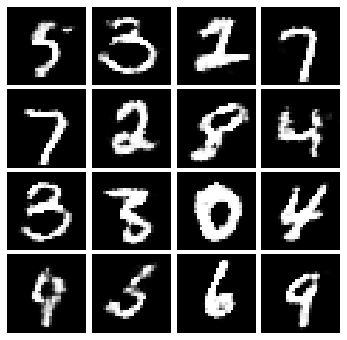

Labels :  (tensor([  4.1775,   6.3064,  13.0623,  12.0932,  12.2132,  12.5037,
          4.5701,   8.9343,   3.8031,  10.6532,  13.8308,   9.8003,
          0.0078,   2.5689,  17.0455,   4.5284], device='cuda:0'), tensor([ 5,  3,  2,  7,  7,  2,  8,  4,  3,  3,  0,  4,  4,  5,
         6,  9], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=34, iteration=127501, WD=18.011878967285156, D_loss=-12.96126651763916, bce=0.13831806182861328, G_loss=-24.0211124420166
epoch=34, iteration=127601, WD=13.856239318847656, D_loss=-7.921046257019043, bce=0.012071371078491211, G_loss=-31.14116668701172
epoch=34, iteration=127701, WD=20.759052276611328, D_loss=-14.803153991699219, bce=0.5721240043640137, G_loss=-60.10942459106445
epoch=34, iteration=127801, WD=2.937633514404297, D_loss=2.1412839889526367, bce=0.050469398498535156, G_loss=-54.77497863769531
epoch=34, iteration=127901, WD=3.082611083984375, D_loss=1.5898170471191406, bce=0.102630615234375, G_loss=-63.09319305419922
epoch=34, ite

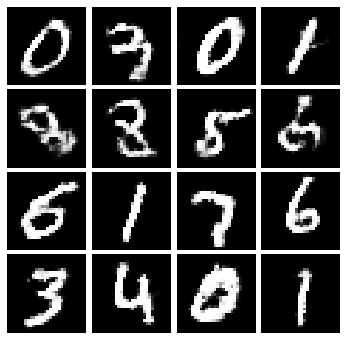

Labels :  (tensor([ 11.0947,   5.5668,  13.7722,   6.6837,  -2.2729,   6.9778,
          8.6041,   1.3387,   4.7814,   7.3614,  10.1952,  10.0874,
         15.1114,   6.2613,   8.2521,   3.8429], device='cuda:0'), tensor([ 0,  3,  0,  1,  3,  3,  5,  6,  5,  1,  7,  6,  3,  4,
         0,  1], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=35, iteration=131301, WD=14.266319274902344, D_loss=-7.469146728515625, bce=1.8018380403518677, G_loss=-72.14292907714844
epoch=35, iteration=131401, WD=8.642807006835938, D_loss=-4.560295104980469, bce=0.017474651336669922, G_loss=-44.25372314453125
epoch=35, iteration=131501, WD=8.494619369506836, D_loss=-1.7671408653259277, bce=0.0008301734924316406, G_loss=20.456941604614258
epoch=35, iteration=131601, WD=15.312671661376953, D_loss=-10.752881050109863, bce=0.06106913089752197, G_loss=-0.29882311820983887
epoch=35, iteration=131701, WD=9.174301147460938, D_loss=-4.126100540161133, bce=0.05879378318786621, G_loss=-90.30598449707031
epoch=3

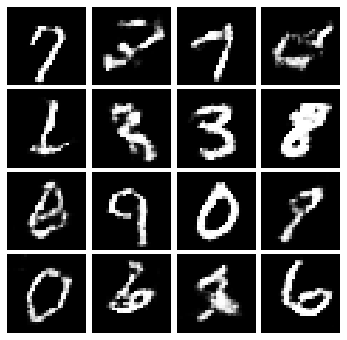

Labels :  (tensor([  6.0522,   4.1646,   6.6671,   0.4546,   6.5328,  -0.0750,
         12.2718,   7.1702,   0.0773,   7.7698,  14.4719,   0.2548,
          7.0784,   7.3313,   3.4421,  14.0645], device='cuda:0'), tensor([ 7,  8,  7,  4,  1,  3,  3,  8,  0,  9,  0,  8,  0,  6,
         2,  6], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=36, iteration=135001, WD=13.855453491210938, D_loss=-8.409524917602539, bce=0.07517600059509277, G_loss=-74.87794494628906
epoch=36, iteration=135101, WD=-2.6902084350585938, D_loss=8.376350402832031, bce=0.3013498783111572, G_loss=-42.201255798339844
epoch=36, iteration=135201, WD=6.080031394958496, D_loss=-0.4220459461212158, bce=0.09807133674621582, G_loss=19.00533103942871
epoch=36, iteration=135301, WD=6.9232940673828125, D_loss=-1.7238702774047852, bce=0.2749900817871094, G_loss=-57.5235710144043
epoch=36, iteration=135401, WD=0.47625732421875, D_loss=6.332920074462891, bce=0.9997575283050537, G_loss=-51.9682502746582
epoch=36, iterati

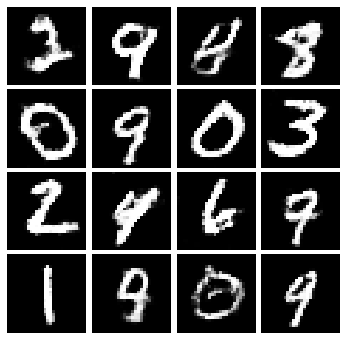

Labels :  (tensor([  1.9857,   7.3653,   6.1835,   6.0209,   7.8217,   8.3096,
          9.8951,  20.9303,  12.3245,   5.6243,  12.5557,   2.5948,
          5.0265,   1.1837,   0.3659,   5.9118], device='cuda:0'), tensor([ 3,  9,  4,  8,  0,  9,  0,  3,  2,  4,  6,  9,  1,  9,
         9,  9], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=37, iteration=138801, WD=13.435787200927734, D_loss=-9.148332595825195, bce=0.00089263916015625, G_loss=-57.17897415161133
epoch=37, iteration=138901, WD=5.965600967407227, D_loss=-1.4483623504638672, bce=0.02512359619140625, G_loss=-15.155921936035156
epoch=37, iteration=139001, WD=8.3369140625, D_loss=-2.997849464416504, bce=0.04100751876831055, G_loss=-22.819210052490234
epoch=37, iteration=139101, WD=5.872570037841797, D_loss=-0.04807502031326294, bce=0.6292998194694519, G_loss=-22.44707679748535
epoch=37, iteration=139201, WD=-0.0707244873046875, D_loss=5.757604122161865, bce=0.06121015548706055, G_loss=-95.22189331054688
epoch=37, iter

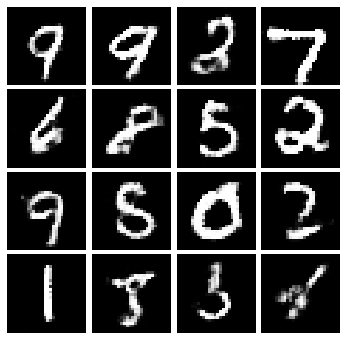

Labels :  (tensor([  5.9784,   8.3298,   5.6093,  20.5489,   3.3235,   6.3681,
          7.0552,   9.6579,   7.2246,   4.0114,   9.0586,   5.2060,
          7.1349,   3.2756,   1.0314,  -2.3703], device='cuda:0'), tensor([ 9,  9,  2,  7,  6,  8,  5,  2,  9,  5,  0,  2,  1,  3,
         3,  4], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=38, iteration=142501, WD=-2.138904333114624, D_loss=8.407114028930664, bce=0.8696718215942383, G_loss=-0.626715898513794
epoch=38, iteration=142601, WD=11.308504104614258, D_loss=-6.272693157196045, bce=0.0021386146545410156, G_loss=-33.634613037109375
epoch=38, iteration=142701, WD=9.113302230834961, D_loss=-4.337881088256836, bce=0.020575523376464844, G_loss=-9.849786758422852
epoch=38, iteration=142801, WD=4.558753967285156, D_loss=0.6303920745849609, bce=0.6153888702392578, G_loss=-90.02334594726562
epoch=38, iteration=142901, WD=12.009025573730469, D_loss=-6.849149227142334, bce=0.021227538585662842, G_loss=-101.026611328125
epoch=38, i

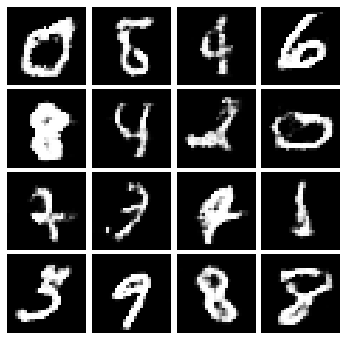

Labels :  (tensor([  6.6810,   5.9011,   1.7660,  15.0009,   9.3467,   5.1237,
          4.3624,   2.9767,  -0.4791,   1.7668,   2.2099,   2.6820,
          5.7979,   7.8995,   7.5122,   8.6448], device='cuda:0'), tensor([ 0,  5,  4,  6,  8,  4,  2,  0,  7,  3,  4,  1,  3,  9,
         8,  8], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=39, iteration=146301, WD=7.509346008300781, D_loss=-3.2992632389068604, bce=0.03976607322692871, G_loss=-75.07136535644531
epoch=39, iteration=146401, WD=23.534812927246094, D_loss=-17.96030044555664, bce=0.43007612228393555, G_loss=-72.2683334350586
epoch=39, iteration=146501, WD=9.514583587646484, D_loss=-4.580358982086182, bce=0.03709602355957031, G_loss=-44.61620330810547
epoch=39, iteration=146601, WD=7.573692321777344, D_loss=-3.1368942260742188, bce=0.0027213096618652344, G_loss=-17.783906936645508
epoch=39, iteration=146701, WD=1.449951171875, D_loss=3.542667865753174, bce=0.18223333358764648, G_loss=-19.755393981933594
epoch=39, ite

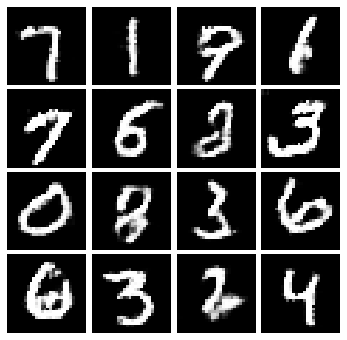

Labels :  (tensor([  9.6158,   5.2656,   3.2547,  -0.3505,   3.8892,   6.0940,
          3.8424,  11.4424,   5.4416,  -2.8936,   7.6776,  22.9915,
         14.4320,  18.5563,   5.3885,   8.7331], device='cuda:0'), tensor([ 7,  1,  9,  6,  7,  6,  2,  3,  0,  8,  3,  6,  6,  3,
         2,  4], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=40, iteration=150001, WD=14.456321716308594, D_loss=-9.0064115524292, bce=0.15241894125938416, G_loss=-16.695314407348633
epoch=40, iteration=150101, WD=12.91864013671875, D_loss=-6.53580379486084, bce=1.0794576406478882, G_loss=-99.29414367675781
epoch=40, iteration=150201, WD=1.1442718505859375, D_loss=5.559116363525391, bce=1.1021493673324585, G_loss=-110.4025650024414
epoch=40, iteration=150301, WD=4.531742095947266, D_loss=0.5722597241401672, bce=0.6070407032966614, G_loss=-44.01517105102539
epoch=40, iteration=150401, WD=7.377606391906738, D_loss=-1.0107276439666748, bce=0.7231218814849854, G_loss=-8.334783554077148
epoch=40, iteration

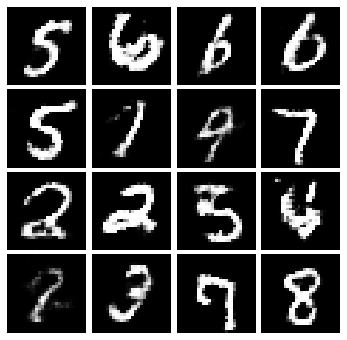

Labels :  (tensor([  7.8639,  23.3611,   4.2390,   6.2181,  14.5687,   3.2774,
          2.3259,  12.0293,  11.5758,  14.8765,   3.3471,   8.1495,
          0.1067,   6.5770,   3.5162,   8.6130], device='cuda:0'), tensor([ 5,  6,  6,  6,  5,  1,  9,  7,  2,  2,  5,  4,  8,  3,
         9,  8], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=41, iteration=153801, WD=4.93023681640625, D_loss=3.506105422973633, bce=3.200000762939453, G_loss=4.756274223327637
epoch=41, iteration=153901, WD=8.798145294189453, D_loss=-3.5292863845825195, bce=0.06983089447021484, G_loss=-19.815380096435547
epoch=41, iteration=154001, WD=21.43692398071289, D_loss=-16.902637481689453, bce=0.06202530860900879, G_loss=-26.899105072021484
epoch=41, iteration=154101, WD=19.90483283996582, D_loss=-15.660158157348633, bce=0.0011677742004394531, G_loss=-32.581146240234375
epoch=41, iteration=154201, WD=3.310352325439453, D_loss=6.709643840789795, bce=4.967941761016846, G_loss=-41.61978530883789
epoch=41, itera

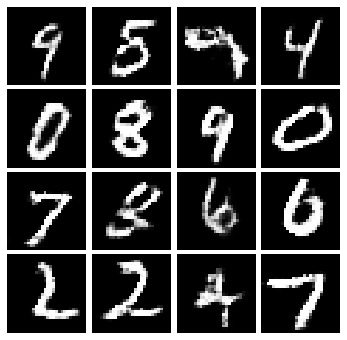

Labels :  (tensor([  4.0257,   9.2294,  -0.9799,   9.4821,   6.5424,   4.1629,
          5.2409,   9.4559,   5.8375,   0.2550,   6.8078,   5.5749,
         13.6160,  18.4910,   1.8668,  14.9323], device='cuda:0'), tensor([ 9,  5,  4,  4,  0,  8,  9,  0,  7,  3,  6,  0,  2,  2,
         4,  7], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=42, iteration=157501, WD=20.506301879882812, D_loss=-14.350768089294434, bce=0.7297905087471008, G_loss=-97.39063262939453
epoch=42, iteration=157601, WD=10.595096588134766, D_loss=-6.237916469573975, bce=0.046911656856536865, G_loss=-21.220312118530273
epoch=42, iteration=157701, WD=20.0494384765625, D_loss=-15.572006225585938, bce=0.0353541374206543, G_loss=1.7514721155166626
epoch=42, iteration=157801, WD=6.927431106567383, D_loss=-1.304903268814087, bce=0.008605718612670898, G_loss=-29.165966033935547
epoch=42, iteration=157901, WD=7.748023986816406, D_loss=-1.962770938873291, bce=1.178579330444336, G_loss=-41.25273132324219
epoch=42, it

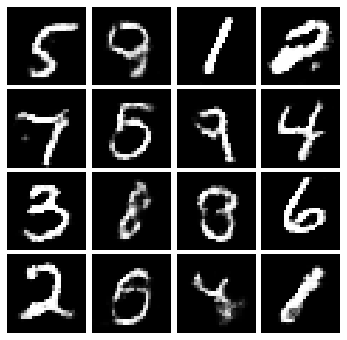

Labels :  (tensor([ 14.8059,   3.0141,   8.4006,  12.9938,   9.2615,   5.8868,
          0.3680,   8.9907,   8.7500,   1.1222,  -0.0816,  11.6269,
         12.8125,   4.1470,   0.5697,   6.6151], device='cuda:0'), tensor([ 5,  9,  1,  2,  7,  5,  3,  4,  3,  8,  0,  6,  2,  5,
         4,  1], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=43, iteration=161301, WD=10.059860229492188, D_loss=-4.991868019104004, bce=0.0027565956115722656, G_loss=-135.83517456054688
epoch=43, iteration=161401, WD=15.773399353027344, D_loss=-10.834983825683594, bce=0.029851794242858887, G_loss=-98.512939453125
epoch=43, iteration=161501, WD=8.853805541992188, D_loss=-4.854386329650879, bce=0.0010156631469726562, G_loss=-46.56251525878906
epoch=43, iteration=161601, WD=13.714851379394531, D_loss=-5.117727756500244, bce=3.4269518852233887, G_loss=-3.7544515132904053
epoch=43, iteration=161701, WD=7.732719421386719, D_loss=-2.4872472286224365, bce=0.003895998001098633, G_loss=-7.603033542633057
epoch

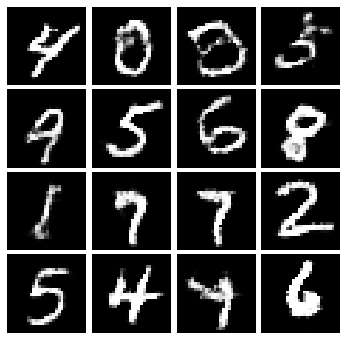

Labels :  (tensor([ 10.1867,   6.2872,  -0.9804,   2.3466,   7.7034,  15.8842,
          2.3541,   8.4625,   2.9538,   6.8918,   8.6185,   8.5993,
         12.0622,  13.1720,   1.7794,  12.1568], device='cuda:0'), tensor([ 4,  0,  3,  5,  9,  5,  6,  8,  1,  7,  7,  2,  5,  4,
         4,  6], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=44, iteration=165001, WD=4.991774559020996, D_loss=0.24619078636169434, bce=0.6028025150299072, G_loss=-16.286531448364258
epoch=44, iteration=165101, WD=11.18292236328125, D_loss=-5.787091255187988, bce=0.22374343872070312, G_loss=26.299907684326172
epoch=44, iteration=165201, WD=-2.376744270324707, D_loss=13.620162963867188, bce=6.653083324432373, G_loss=-18.00882911682129
epoch=44, iteration=165301, WD=2.325916290283203, D_loss=3.078993082046509, bce=0.01078343391418457, G_loss=-45.93906021118164
epoch=44, iteration=165401, WD=14.021682739257812, D_loss=-9.133766174316406, bce=0.0008282661437988281, G_loss=-77.77276611328125
epoch=44, ite

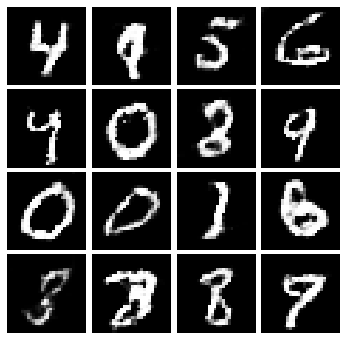

Labels :  (tensor([ 11.4963,   1.2826,   3.1457,   8.6624,   4.2187,  12.1875,
          2.1573,   2.5980,  14.7129,   7.5081,   5.2717,   9.3234,
          0.8161,   7.3535,   5.4368,   0.1180], device='cuda:0'), tensor([ 4,  9,  5,  6,  4,  0,  2,  4,  0,  0,  1,  6,  8,  3,
         8,  7], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=45, iteration=168801, WD=8.566909790039062, D_loss=-2.9567184448242188, bce=0.6970863342285156, G_loss=-83.55741882324219
epoch=45, iteration=168901, WD=18.73065948486328, D_loss=-13.559957504272461, bce=0.07559859752655029, G_loss=-57.61271286010742
epoch=45, iteration=169001, WD=14.22357177734375, D_loss=-8.619041442871094, bce=0.05294609069824219, G_loss=-101.6333236694336
epoch=45, iteration=169101, WD=8.745269775390625, D_loss=-4.120209693908691, bce=0.3381505012512207, G_loss=-53.15631866455078
epoch=45, iteration=169201, WD=7.370259761810303, D_loss=-2.047236919403076, bce=0.02697134017944336, G_loss=0.6212034225463867
epoch=45, itera

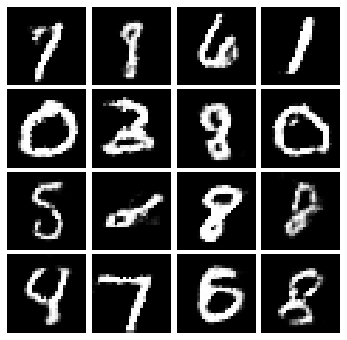

Labels :  (tensor([  5.4837,  -1.0651,   8.6430,   7.4296,  14.4262,   3.1099,
          3.7635,   8.0747,   3.6808,  -3.3909,  10.0265,   1.6605,
          4.5057,  12.2472,   4.2192,   0.5643], device='cuda:0'), tensor([ 7,  8,  6,  1,  0,  2,  8,  0,  5,  2,  8,  8,  4,  7,
         5,  8], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=46, iteration=172501, WD=2.4276123046875, D_loss=2.744847536087036, bce=0.0036309361457824707, G_loss=-73.06348419189453
epoch=46, iteration=172601, WD=0.609649658203125, D_loss=6.571951866149902, bce=2.6945600509643555, G_loss=-72.09906005859375
epoch=46, iteration=172701, WD=5.3780364990234375, D_loss=-1.095617413520813, bce=0.10122382640838623, G_loss=-58.02055358886719
epoch=46, iteration=172801, WD=15.474235534667969, D_loss=-9.776029586791992, bce=0.4740649461746216, G_loss=-47.106971740722656
epoch=46, iteration=172901, WD=12.515174865722656, D_loss=-8.295748710632324, bce=0.310824453830719, G_loss=-36.07621765136719
epoch=46, iterati

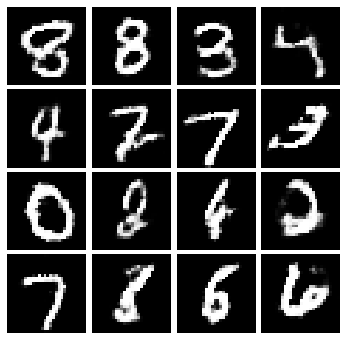

Labels :  (tensor([  2.6165,   2.8348,  11.5509,  -1.2757,   5.3945,   6.4652,
         10.1418,  -0.8603,  13.9985,   0.8032,   2.1230,   7.0289,
          6.8255,  -1.4288,   8.9315,  14.1570], device='cuda:0'), tensor([ 8,  8,  3,  4,  4,  2,  7,  3,  0,  2,  6,  2,  7,  8,
         6,  6], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=47, iteration=176301, WD=21.512985229492188, D_loss=-17.068574905395508, bce=0.016504526138305664, G_loss=-73.10994720458984
epoch=47, iteration=176401, WD=11.872766494750977, D_loss=-7.2298784255981445, bce=0.036563873291015625, G_loss=22.438255310058594
epoch=47, iteration=176501, WD=13.312782287597656, D_loss=-7.6071295738220215, bce=0.07734239101409912, G_loss=-40.419803619384766
epoch=47, iteration=176601, WD=5.902503967285156, D_loss=-1.388637661933899, bce=0.27761590480804443, G_loss=-47.86566162109375
epoch=47, iteration=176701, WD=11.542461395263672, D_loss=-7.383162498474121, bce=0.0019030570983886719, G_loss=-47.74565505981445
epo

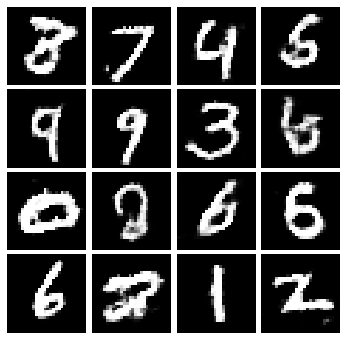

Labels :  (tensor([ -0.0756,   8.9611,   2.5284,   1.1592,   1.0663,   3.5810,
         11.0085,  10.8534,  14.8241,  -1.4543,   7.8696,   3.0291,
         11.7234,   3.4912,   6.4133,   8.7639], device='cuda:0'), tensor([ 8,  7,  9,  6,  9,  9,  3,  6,  0,  8,  6,  6,  6,  2,
         1,  2], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=48, iteration=180001, WD=23.96623992919922, D_loss=-17.97069549560547, bce=0.2330428510904312, G_loss=52.8631591796875
epoch=48, iteration=180101, WD=6.706939697265625, D_loss=-1.2364660501480103, bce=0.11865842342376709, G_loss=-123.31285095214844
epoch=48, iteration=180201, WD=19.17115020751953, D_loss=-14.339280128479004, bce=0.040383338928222656, G_loss=-63.7314338684082
epoch=48, iteration=180301, WD=16.683666229248047, D_loss=-11.601819038391113, bce=1.0454216003417969, G_loss=20.086538314819336
epoch=48, iteration=180401, WD=16.601219177246094, D_loss=-11.345941543579102, bce=0.33169713616371155, G_loss=4.576172828674316
epoch=48, ite

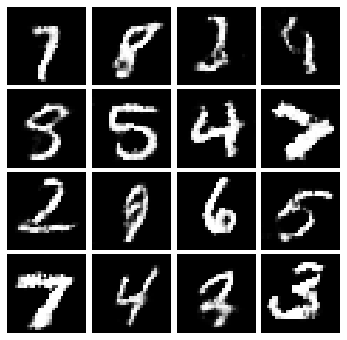

Labels :  (tensor([  7.3527,   1.9002,   0.9866,  -2.4845,   1.4828,   9.3834,
          7.5602,  -0.9604,   4.5103,   0.3008,  13.3287,   5.3131,
         10.2166,   6.6368,  -2.5247,   7.7451], device='cuda:0'), tensor([ 7,  8,  3,  7,  5,  5,  4,  2,  2,  9,  6,  5,  7,  4,
         7,  3], device='cuda:0'))
Classification Accuracy : 98 % 
epoch=49, iteration=183801, WD=11.331180572509766, D_loss=-6.9624247550964355, bce=0.1372891664505005, G_loss=-36.922080993652344
epoch=49, iteration=183901, WD=5.9080810546875, D_loss=-1.708517074584961, bce=0.03588056564331055, G_loss=-85.14923858642578
epoch=49, iteration=184001, WD=26.55988311767578, D_loss=-21.84465217590332, bce=0.025177001953125, G_loss=-88.49874114990234
epoch=49, iteration=184101, WD=13.649374008178711, D_loss=-10.147780418395996, bce=0.0043288469314575195, G_loss=-27.939725875854492
epoch=49, iteration=184201, WD=1.5850639343261719, D_loss=3.0905022621154785, bce=0.0032123327255249023, G_loss=3.8742434978485107
epoch=49,

In [0]:
g = Generator().cuda()
d = Discriminator().cuda()
loss = train(g,d,l=1e-4,n_epochs=50, weight_decay=False)

In [0]:
loss = np.array(loss)

Text(0,0.5,'Wasserstein Distance')

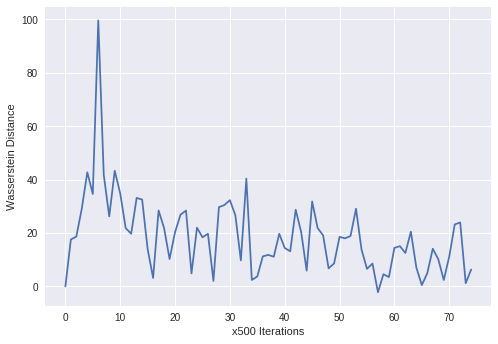

In [0]:
loss = np.array(loss)
plt.plot(loss[::500,0])
plt.xlabel("x500 Iterations")
plt.ylabel("Wasserstein Distance")

Text(0,0.5,'Discriminator Loss')

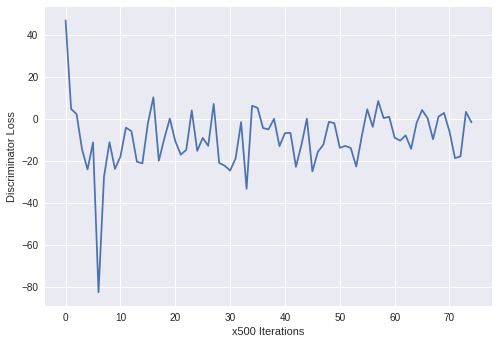

In [0]:
plt.plot(loss[::500,1])
plt.xlabel("x500 Iterations")
plt.ylabel("Discriminator Loss")

Text(0,0.5,'Crossentropy - No size average')

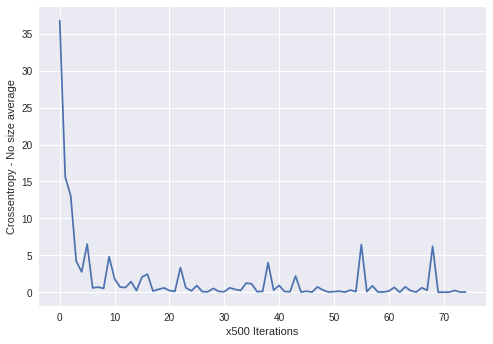

In [0]:
plt.plot(loss[::500,2])
plt.xlabel("x500 Iterations")
plt.ylabel("Crossentropy - No size average")

Text(0,0.5,'Generator Loss')

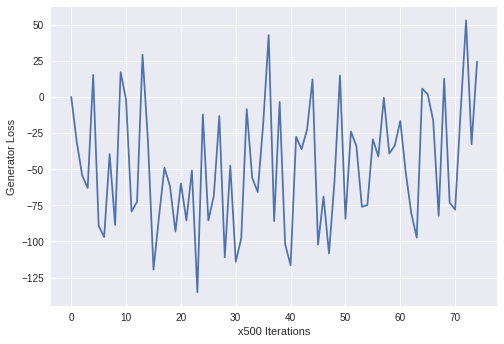

In [0]:
plt.plot(loss[::500,3])
plt.xlabel("x500 Iterations")
plt.ylabel("Generator Loss")